# Deep Learning Technique in Finance

## References:
- TabNet Paper: https://arxiv.org/pdf/1908.07442.pdf
- TabNet Examples: https://nbviewer.org/github/dreamquark-ai/tabnet/blob/develop/census_example.ipynb

## Deep Learning for Tabular Data using Fastai
- Benefits of Using Fastai:
  - Automatically handle data preprocessing
  - provide APIs that simplify working with ANNs
  - It corporates with a selection of empirically tested best approaches in various tasks. For example, NLP, image processing...
  - `Entity embedding` for categorical data
    - Models can learn the potential relationship between observations of categorical features with embedded matrix and vector by mapping similar values close to each other.
    - It reduce training memory usage and time consuming.
    - Avoid overfitting problem.

In [2]:
!pip install fastai
import fastai
from fastai import *
from fastai.tabular.all import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
!pip install yfinance
import yfinance as yf
import torch
import sklearn
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-2-58c347ac339b>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def performance_evaluation_report_fastai(model, valid_set, show_plot=False, labels=None, show_pr_curve=False):
    """
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : fastai Learner
        A trained model for Tabular data
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    """

    preds_valid, y_test = model.get_preds(dl=valid_set)
    y_pred = preds_valid.argmax(dim=-1)
    y_pred_prob = preds_valid.numpy()[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = metrics.precision_score(y_test, y_pred),
    recall = metrics.recall_score(y_test, y_pred),

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, _ = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 20 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle("Performance Evaluation", fontsize=16)

        # plot 1: confusion matrix ----
        # preparing more descriptive labels for the confusion matrix
        cm_counts = [f"{val:0.0f}" for val in cm.flatten()]
        cm_percentages = [f"{val:.2%}" for val in cm.flatten()/np.sum(cm)]
        cm_labels = [f"{v1}\n{v2}" for v1, v2 in zip(cm_counts,cm_percentages)]
        cm_labels = np.asarray(cm_labels).reshape(2,2)

        sns.heatmap(cm, annot=cm_labels, fmt="", linewidths=.5, cmap="Greens", 
                    square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": "center", "va": "center"})
        ax[0].set(xlabel="Predicted label",
                  ylabel="Actual label", 
                  title="Confusion Matrix")
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        # plot 2: ROC curve ----
        
        ax[1].plot(fpr, tpr, "b-", 
                   label=f"ROC-AUC = {roc_auc:.2f}")
        ax[1].set(xlabel="False Positive Rate",
                  ylabel="True Positive Rate", 
                  title="ROC Curve")
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), "ro",
                   markersize=8, label="Decision Point")
        ax[1].plot([0, 1], [0, 1], "r--")
        ax[1].legend(loc="lower right")
        
        # plot 3: Precision-Recall curve ----
        if show_pr_curve:
          ax[2].plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}")
          ax[2].set(xlabel="Recall", ylabel="Precision",
                    title="Precision-Recall Curve")
          ax[2].legend()

    stats = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "precision": metrics.precision_score(y_test, y_pred),
        "recall": metrics.recall_score(y_test, y_pred),
        "specificity": (tn / (tn + fp)),
        "f1_score": metrics.f1_score(y_test, y_pred),
        "cohens_kappa": metrics.cohen_kappa_score(y_test, y_pred),
        "matthews_corr_coeff": metrics.matthews_corrcoef(y_test, y_pred),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "average_precision": metrics.average_precision_score(y_test, y_pred_prob)
        }

    return stats

In [4]:
#import data
data=pd.read_csv('/content/credit_card_default.csv',na_values="")

In [ ]:
data.head()

,Unnamed: 0,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,...,0,0,0,0,689,0,0,0,0,1
1,1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
#define the numerical/categorical features, target feature(dependent variable), and preprocessing steps
#reference: https://docs.fast.ai/tutorial.tabular.html
target="default_payment_next_month"
categorical_feature=list(data.select_dtypes('object').columns)
numerical_feature=list(data.select_dtypes('number').columns)
numerical_feature.remove(target)
preprocessing = [FillMissing, Categorify, Normalize]

In [ ]:
#define the splitter to create training and vaildation datasets
#random 80/20 split
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(data))
splits

((#24000) [27362,16258,19716,9066,1258,23042,18939,24443,4328,4976...],
 (#6000) [7542,10109,19114,5209,9270,15555,12970,10207,13694,1745...])

In [ ]:
#create a TabularPandas class
to=TabularPandas(
    data,
    procs=preprocessing,
    cat_names=categorical_feature,
    cont_names=numerical_feature,
    y_names=target,
    y_block=CategoryBlock(),
    splits=splits
)

In [ ]:
#check the result after preprocessing and data splits
to.xs.iloc[:5]

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,...,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr
27362,2,4,3,10,10,10,10,9,9,1,...,-0.677017,-0.672893,-0.663007,-0.651924,-0.256331,-0.254758,-0.298697,-0.304028,-0.318804,-0.296031
16258,1,4,1,10,10,10,3,2,2,1,...,0.934085,0.979670,1.140510,1.131389,-0.023655,0.217783,-0.298697,0.203350,-0.318804,-0.071704
19716,1,1,3,2,3,10,10,2,9,1,...,-0.474143,-0.437195,-0.421307,-0.376903,-0.339855,-0.125883,-0.099563,-0.304028,-0.184951,-0.182361
9066,1,2,3,3,3,3,3,1,1,1,...,-0.643404,-0.672893,-0.572727,-0.560654,-0.149359,-0.254758,-0.298697,0.039647,0.043604,-0.004809
1258,2,1,3,1,1,1,1,1,1,1,...,-0.672830,-0.668359,-0.655730,-0.647019,-0.322494,-0.242257,-0.282140,-0.276325,-0.299329,-0.279492


In [ ]:
#build a data loader
dls=to.dataloaders(bs=64, drop_last=True)
dls.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,Unnamed: 0,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,28355.999586,170000.000120,43.000000,136112.997034,137721.997800,139383.996422,141314.001179,139251.999774,139204.996952,7000.000001,7000.000017,6999.999959,5099.999995,5299.999988,5029.999999,0
1,Male,Graduate school,Single,Payed duly,Payed duly,Payed duly,Unknown,Unknown,Unknown,False,27350.000308,199999.999270,32.000000,1124.999386,2181.999299,-0.000269,-0.000013,0.001374,0.001333,2182.000058,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,1
2,Female,Graduate school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Payed duly,False,27866.000328,70000.000530,25.000001,69334.000302,66987.000219,58055.000365,44593.000020,-1379.998894,48757.000265,2999.999987,2213.000007,1565.000122,-0.000076,50136.999881,1799.999979,0
3,Female,High school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,14713.999998,49999.996248,33.000000,39846.999862,37561.000370,36724.999664,35345.999810,33809.999805,32788.000140,1719.000090,1782.999972,1199.999873,1200.000066,1500.000086,1000.000099,0
4,Male,Graduate school,Single,Unknown,Unknown,Unknown,Unknown,Payed duly,Payed duly,False,23969.000262,140000.000001,26.000000,17375.999892,4879.001334,6266.001178,4378.999649,420.001769,0.001333,4906.999988,6283.999994,4391.999971,419.999962,0.000058,244.999904,0
5,Male,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,20978.999950,119999.999598,41.000000,0.000274,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,1
6,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Payment delayed 2 months,Payment delayed 2 months,False,16248.000053,170000.000120,44.999999,133341.000912,133715.003192,130590.996319,138403.997580,138733.000678,137642.003151,6803.999989,6883.000043,11600.000009,5019.999994,1199.999991,4000.000042,0
7,Female,Graduate school,Married,Payed duly,Payed duly,Unknown,Unknown,Unknown,Unknown,False,13798.000018,209999.999471,35.000000,3804.998915,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,0
8,Female,High school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,4711.000304,130000.001739,42.000000,127524.003848,127839.000798,128380.002460,97712.999810,96245.000257,95779.001106,5050.999998,5100.999984,3599.999945,3501.000054,3799.999959,3412.000031,0
9,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,15817.000021,179999.999837,27.000000,114556.001884,116154.999334,120263.997494,124203.002201,125702.000600,128733.999389,4999.999994,6000.000003,6000.000017,4999.999993,5000.000005,10000.000060,0


In [ ]:
#define a tabular learner
#reference: https://docs.fast.ai/tabular.learner.html#tabular_learner
#https://docs.fast.ai/metrics.html
recall = Recall()
precision = Precision()
learn=tabular_learner(dls,
                      layers=[1000, 500], 
                      metrics=[accuracy, recall, precision]) 
#check the structure
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3-6): 4 x Embedding(11, 6)
    (7-8): 2 x Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=64, out_features=1000, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=1000, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=500, out_features=2, bias=True)
    )
  )
)

- Embedding(4,3): a categorical embedding was created with 4 input values and 3 output latent features.

SuggestedLRs(valley=0.0020892962347716093)

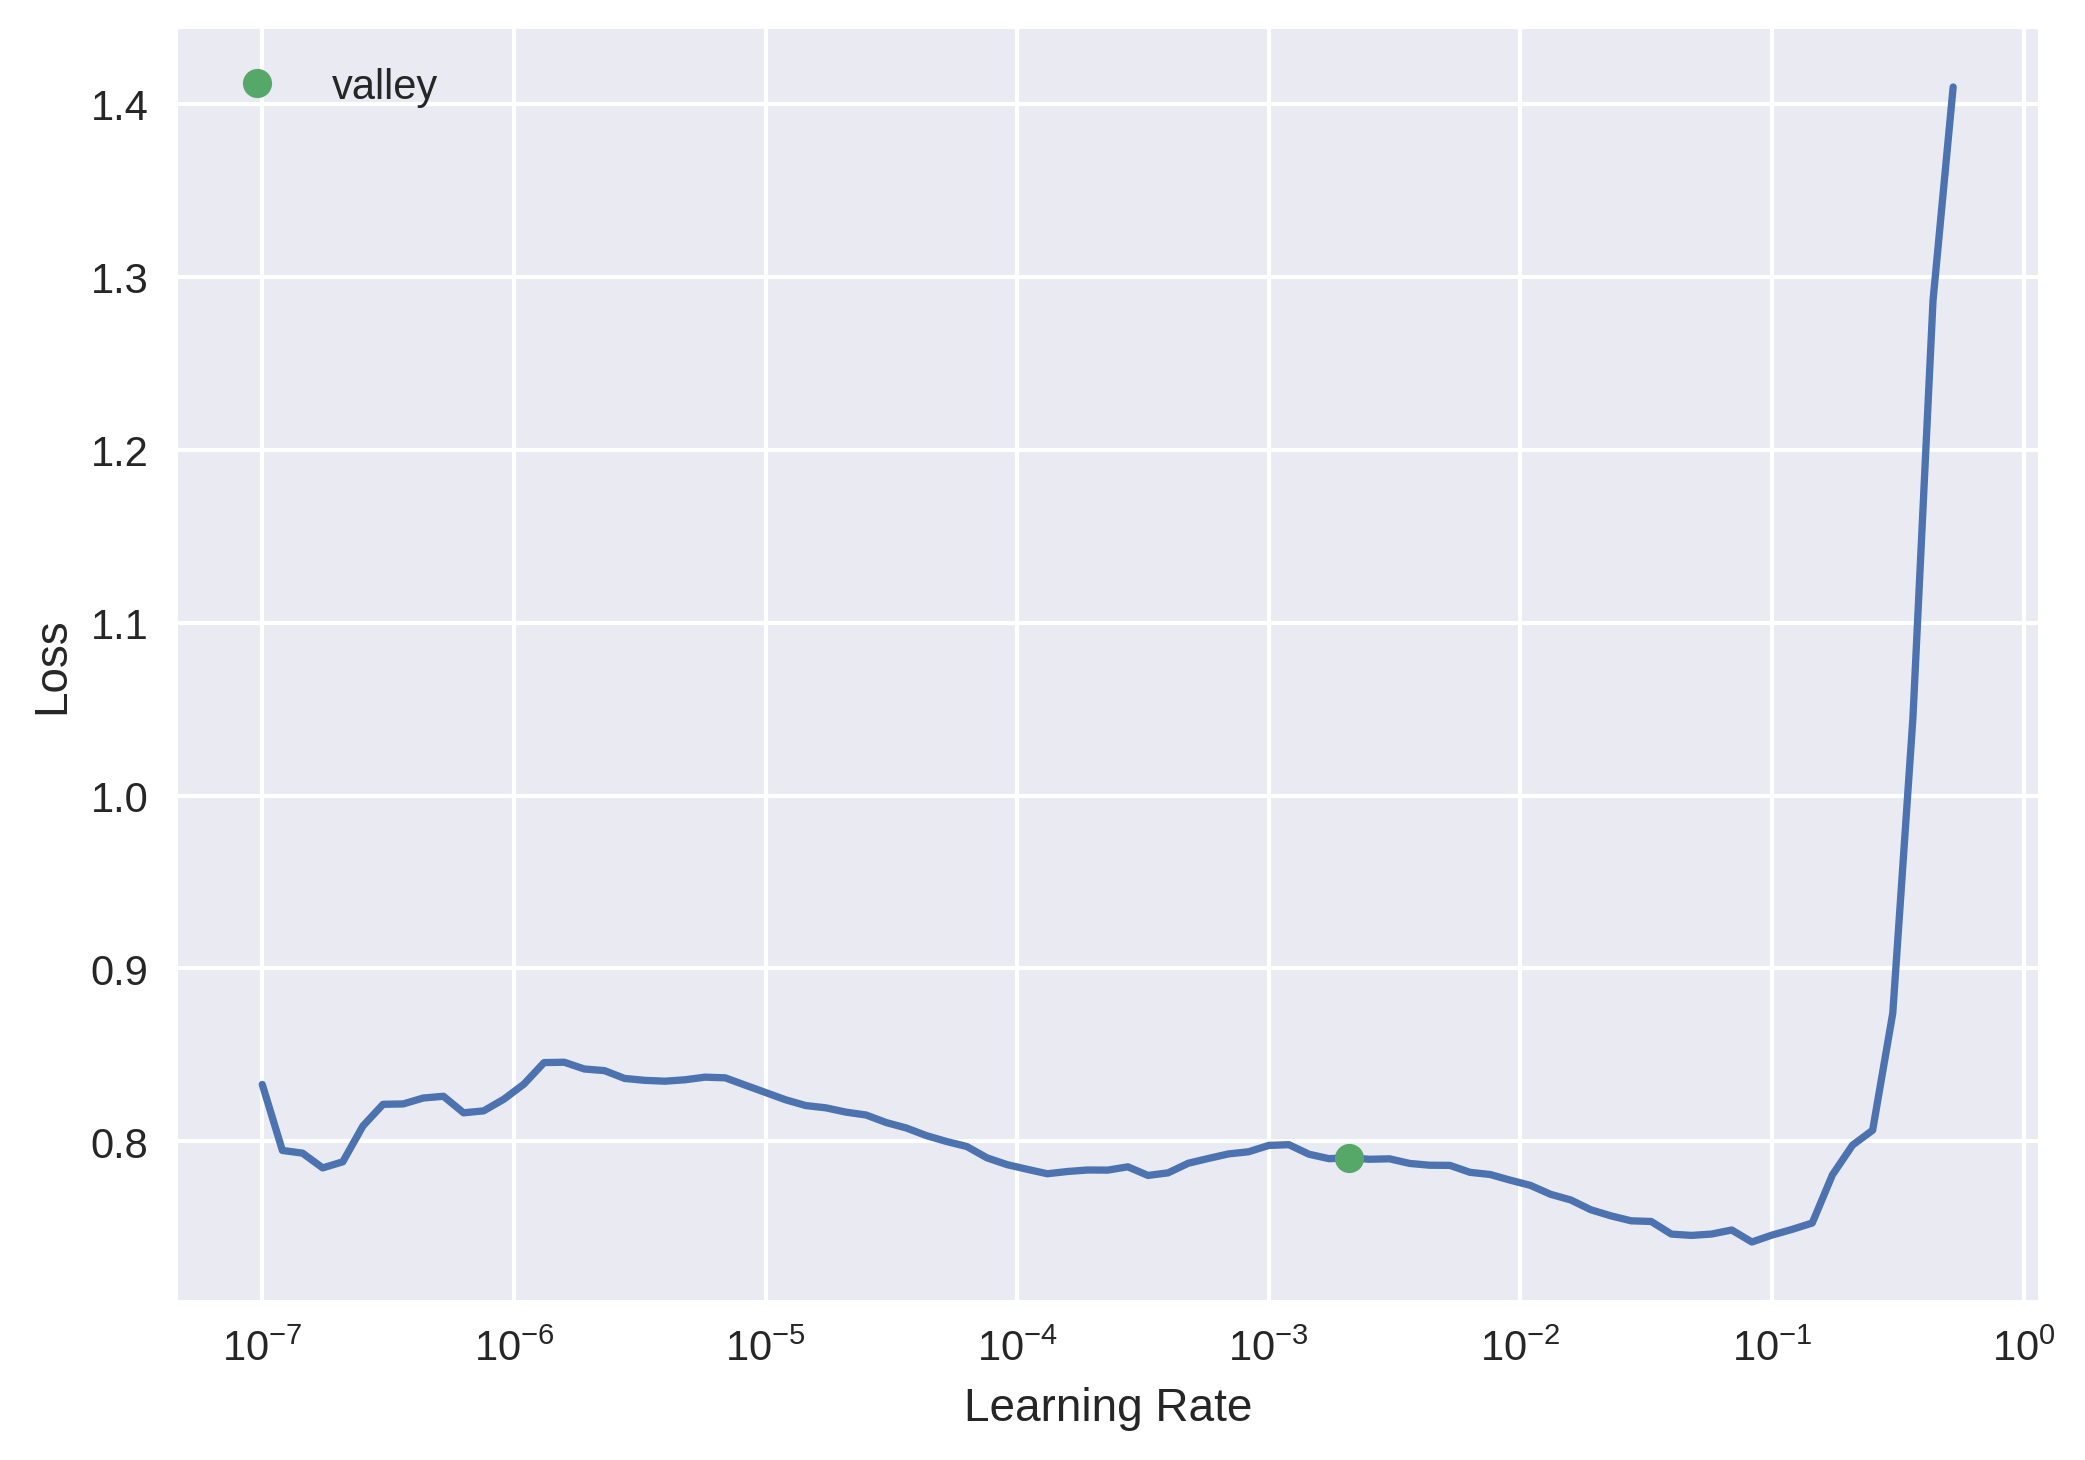

In [ ]:
#find the learning rate suggested
learn.lr_find()

In [ ]:
#train the tabular learner
learn.fit(n_epoch=25, lr=1e-3, wd=0.2)  #wd:weight decay

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.456353,0.436502,0.817833,0.259781,0.693111,00:10
1,0.452274,0.442500,0.812333,0.286385,0.631034,00:10
2,0.447873,0.429388,0.822000,0.403756,0.627737,00:10
3,0.437258,0.423624,0.825167,0.374804,0.657064,00:10
4,0.439349,0.425889,0.826500,0.388106,0.656954,00:10
5,0.445856,0.428047,0.822833,0.359155,0.652916,00:12
6,0.426531,0.424744,0.825000,0.354460,0.668142,00:13
7,0.425405,0.430017,0.825833,0.358372,0.670571,00:17
8,0.439025,0.423812,0.825167,0.383412,0.652463,00:20
9,0.433197,0.423514,0.825667,0.372457,0.661111,00:11


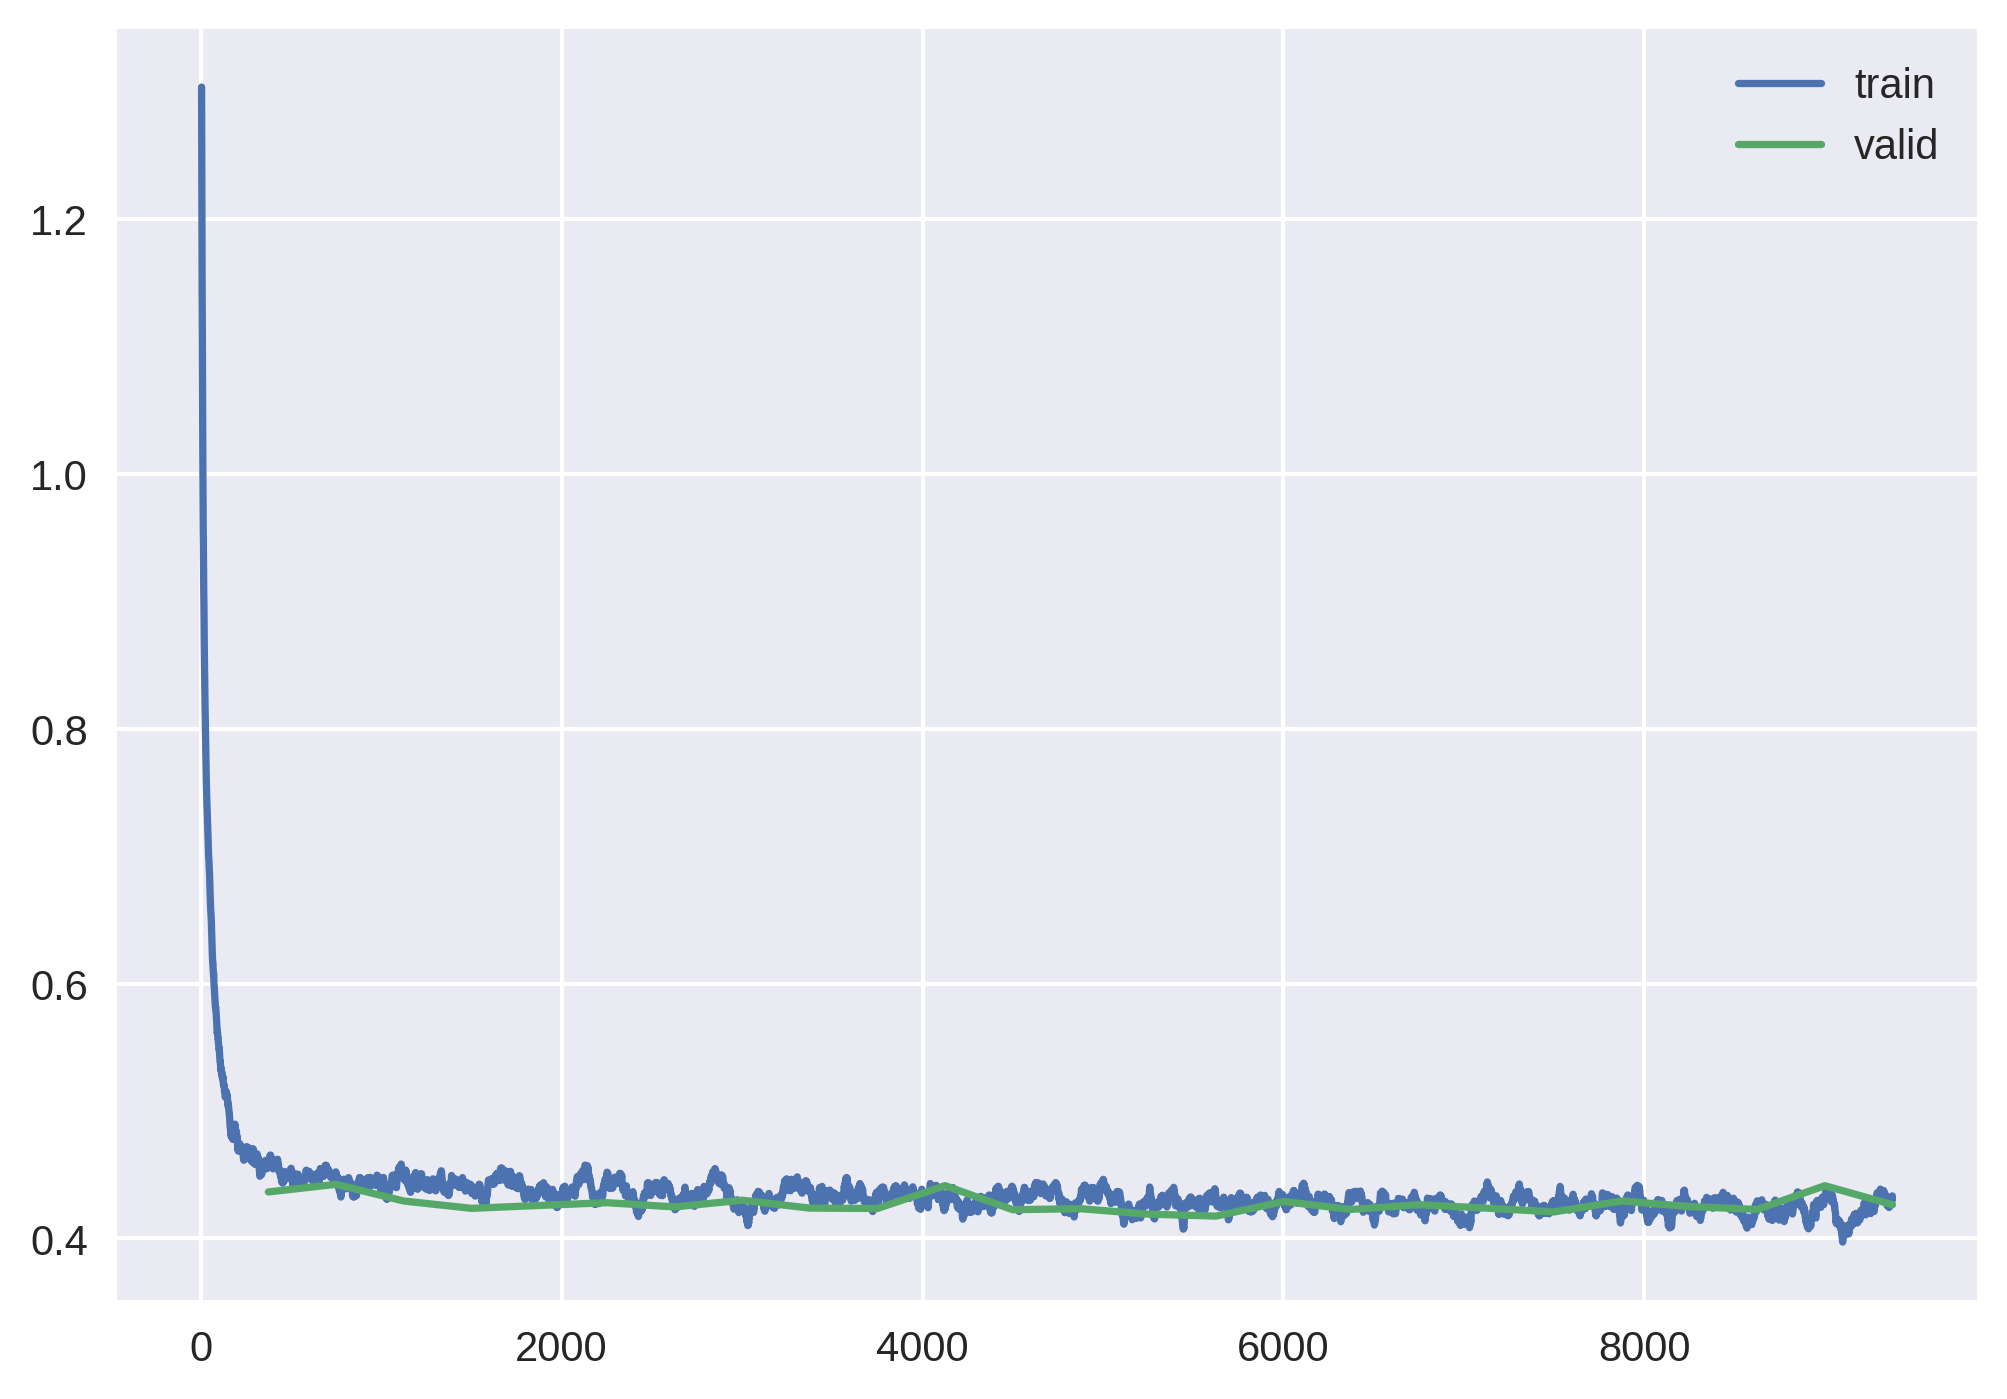

In [ ]:
learn.recorder.plot_loss()
#https://docs.fast.ai/learner.html#recorder-1

In [ ]:
#define the data loader of vaildation
valid_data_loader = learn.dls.test_dl(data.loc[list(splits[1])])
valid_data_loader.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,Unnamed: 0,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,Graduate school,Single,Payment delayed 1 month,Unknown,Unknown,Unknown,Payed duly,Payed duly,False,7542.000129,80000.002671,28.0,0.000274,-0.001422,-0.000269,-0.000013,2284.000497,-786.000871,0.000039,-0.000043,-0.000163,2283.999916,0.000058,-0.000013,1
1,Female,Graduate school,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,10108.999848,360000.000553,44.0,347695.995104,329863.996200,322158.997157,289376.998417,146945.999005,130085.003447,19999.999860,20008.999765,30000.000210,9999.999766,9999.999951,10000.000060,0
2,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,19113.999880,80000.002671,31.0,0.000274,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,0
3,Female,University,Married,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,False,5209.000035,49999.996248,43.0,560.001359,1120.999531,194.999217,196.998524,196.998239,197.000509,1121.000175,194.999828,197.000070,197.000190,196.999852,196.999786,0
4,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,9269.999979,179999.999837,26.0,145574.003103,108616.999401,102710.999113,95651.998160,97661.001694,99655.998778,3906.999985,3600.000028,3414.999937,3541.999967,3615.999970,1999.999949,0
5,Male,University,Single,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Unknown,Payed duly,False,15554.999968,20000.005341,37.0,3254.001134,2521.998928,-0.000269,779.998506,390.000193,390.000078,1999.999921,-0.000043,780.000096,-0.000076,389.999981,1679.999945,1
6,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,12970.000025,279999.998942,44.0,286706.004848,272243.004586,203743.992187,203520.005928,207877.993990,211811.996533,10480.000231,8041.000065,7200.000052,7499.999924,7092.999917,5701.999989,0
7,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,10207.000216,80000.002671,26.0,76157.999269,81858.000996,80337.000365,61002.000665,58147.999258,52514.999924,8000.000067,4999.999988,4000.000000,4999.999993,3000.000004,5000.000007,0
8,Male,Graduate school,Married,Unknown,Unknown,Unknown,Payed duly,Payed duly,Payed duly,False,13693.999941,209999.999471,52.0,44933.000212,38541.999976,39331.999888,11140.000617,8462.999592,10406.000874,1792.999970,8242.000014,12000.000196,8533.999995,11000.000119,7500.000042,0
9,Female,Graduate school,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,1744.999862,49999.996248,22.0,49459.000028,49281.000000,50071.000110,10104.000406,9208.000207,10075.000742,2299.999941,2000.000073,1000.000042,500.000082,999.999780,500.000043,0


In [ ]:
#generate the performance of validation set
learn.validate(dl=valid_data_loader)

(#4) [0.4264780580997467,0.8261666893959045,0.3779342723004695,0.6607387140902873]

In [ ]:
#get predictions for validation dataset
preds, y_true = learn.get_preds(dl=valid_data_loader)

In [ ]:
preds

tensor([[0.8182, 0.1818],
        [0.7215, 0.2785],
        [0.8527, 0.1473],
        ...,
        [0.9527, 0.0473],
        [0.8881, 0.1119],
        [0.8789, 0.1211]])

In [ ]:
y_true

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

{'accuracy': 0.8261666666666667,
 'precision': 0.6607387140902873,
 'recall': 0.3779342723004695,
 'specificity': 0.9474798814061838,
 'f1_score': 0.480836236933798,
 'cohens_kappa': 0.3856010329913985,
 'matthews_corr_coeff': 0.4073259404715768,
 'roc_auc': 0.7703379910504486,
 'pr_auc': 0.5332621796759522,
 'average_precision': 0.5337383755087362}

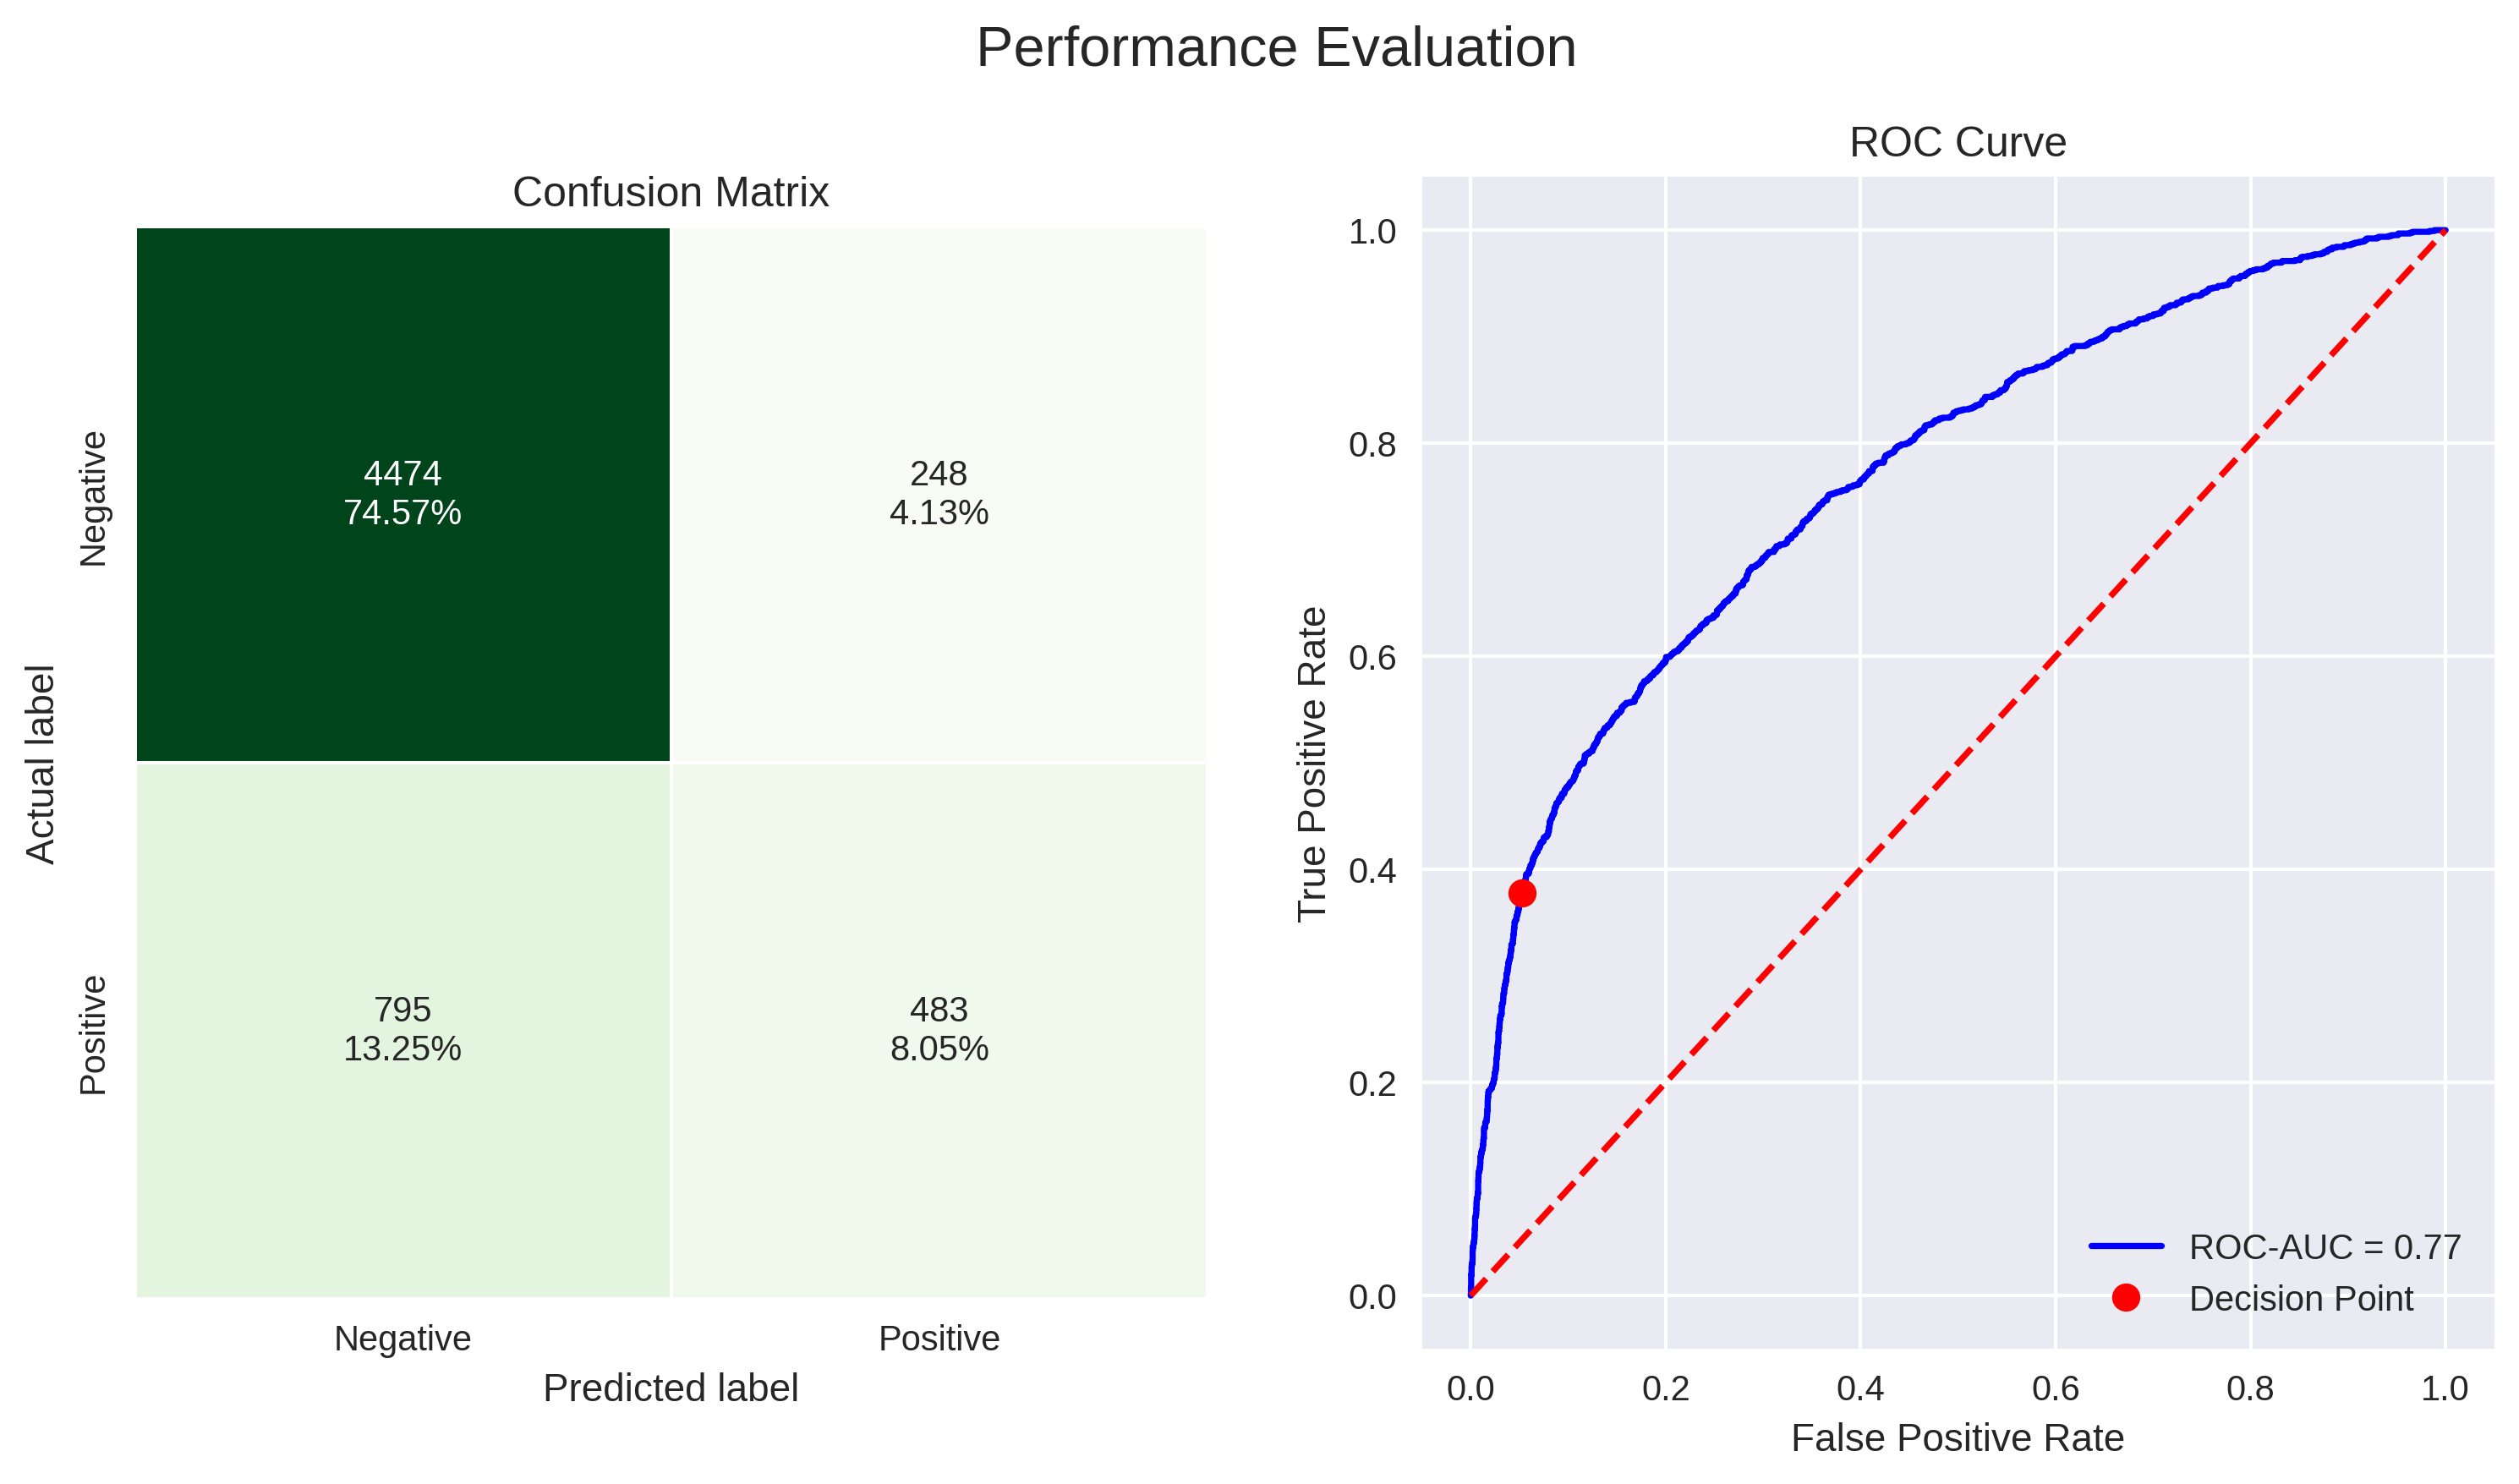

In [ ]:
performance = performance_evaluation_report_fastai(learn, valid_data_loader, show_plot=True)
performance

## Exploring Google TabNet
- TabNet use raw tabular data without any preprocessing.
- Optimization is based on <u>gradient descent</u>
- It combines feauture selection of tree-based models and netural network, using `sequential attention` to choose features at each decision step.
- Two building blocks: 
  - feature transformer: change feature into useful representation
  - attentive transformer: select *most relevant features* to next step.
- Has a *learnable mask* of input features
  - sparse
  - select a small set of features to solve prediction task.
  - the decisions can be made by a large range of values rather than only a threshold.
- Local interpretabilities: 
  - visualize feature importance
  - how they are combined for a single row
- Global interpretabilities:
  - provide each feature's contribution of train model

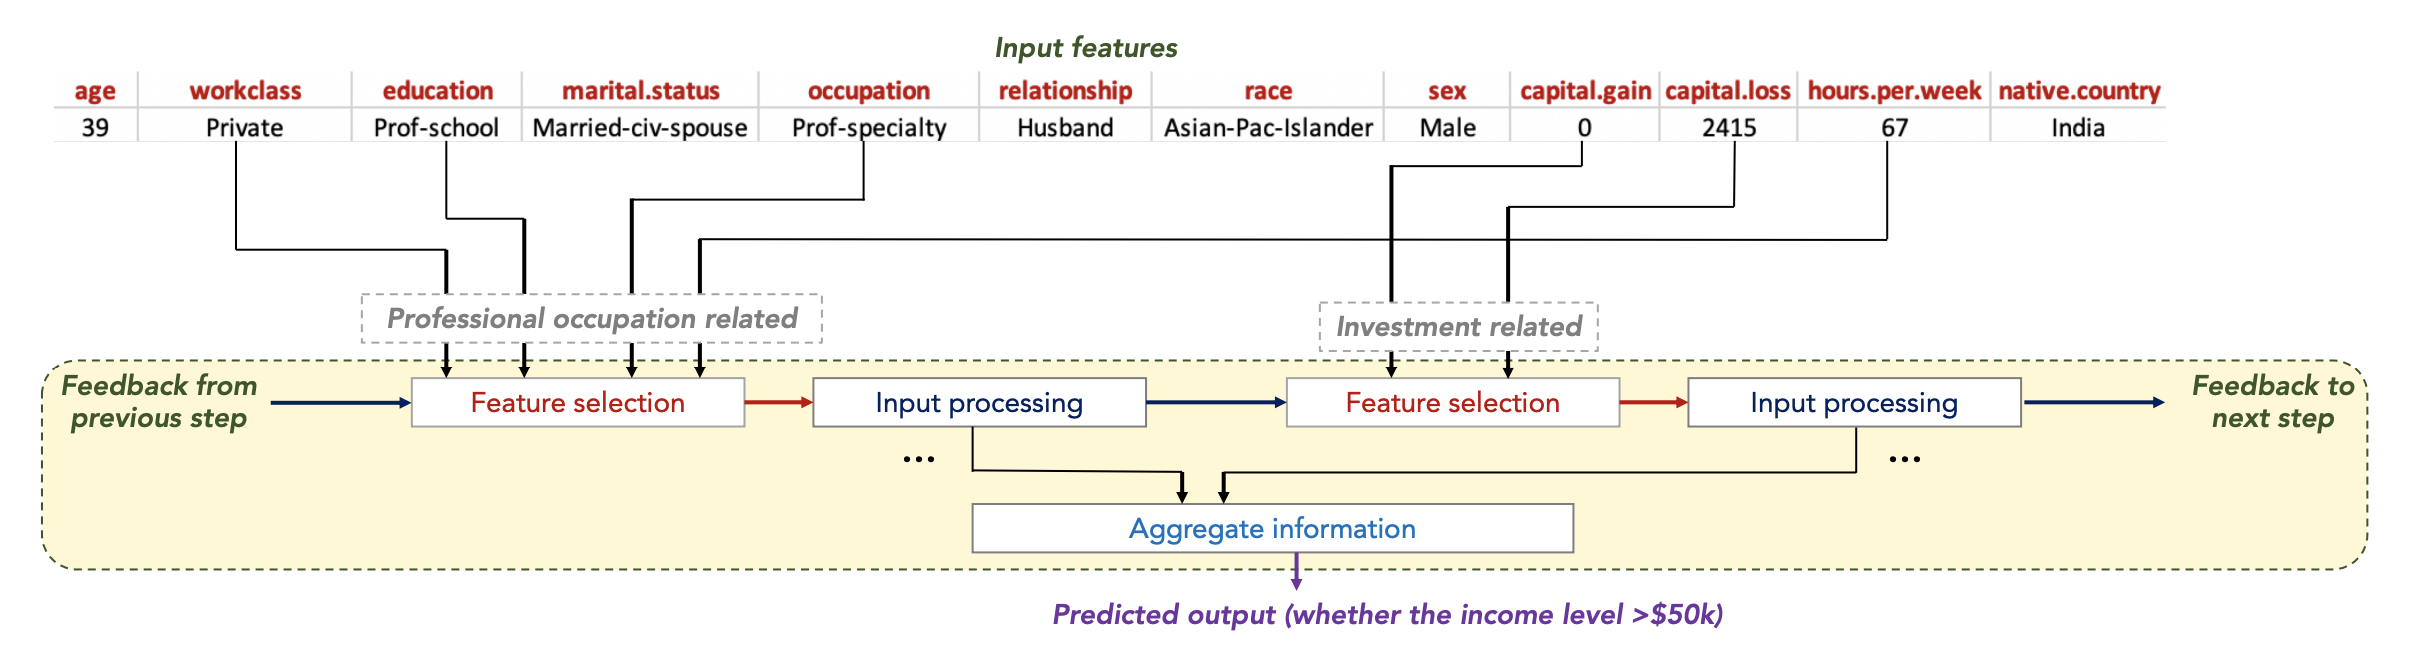

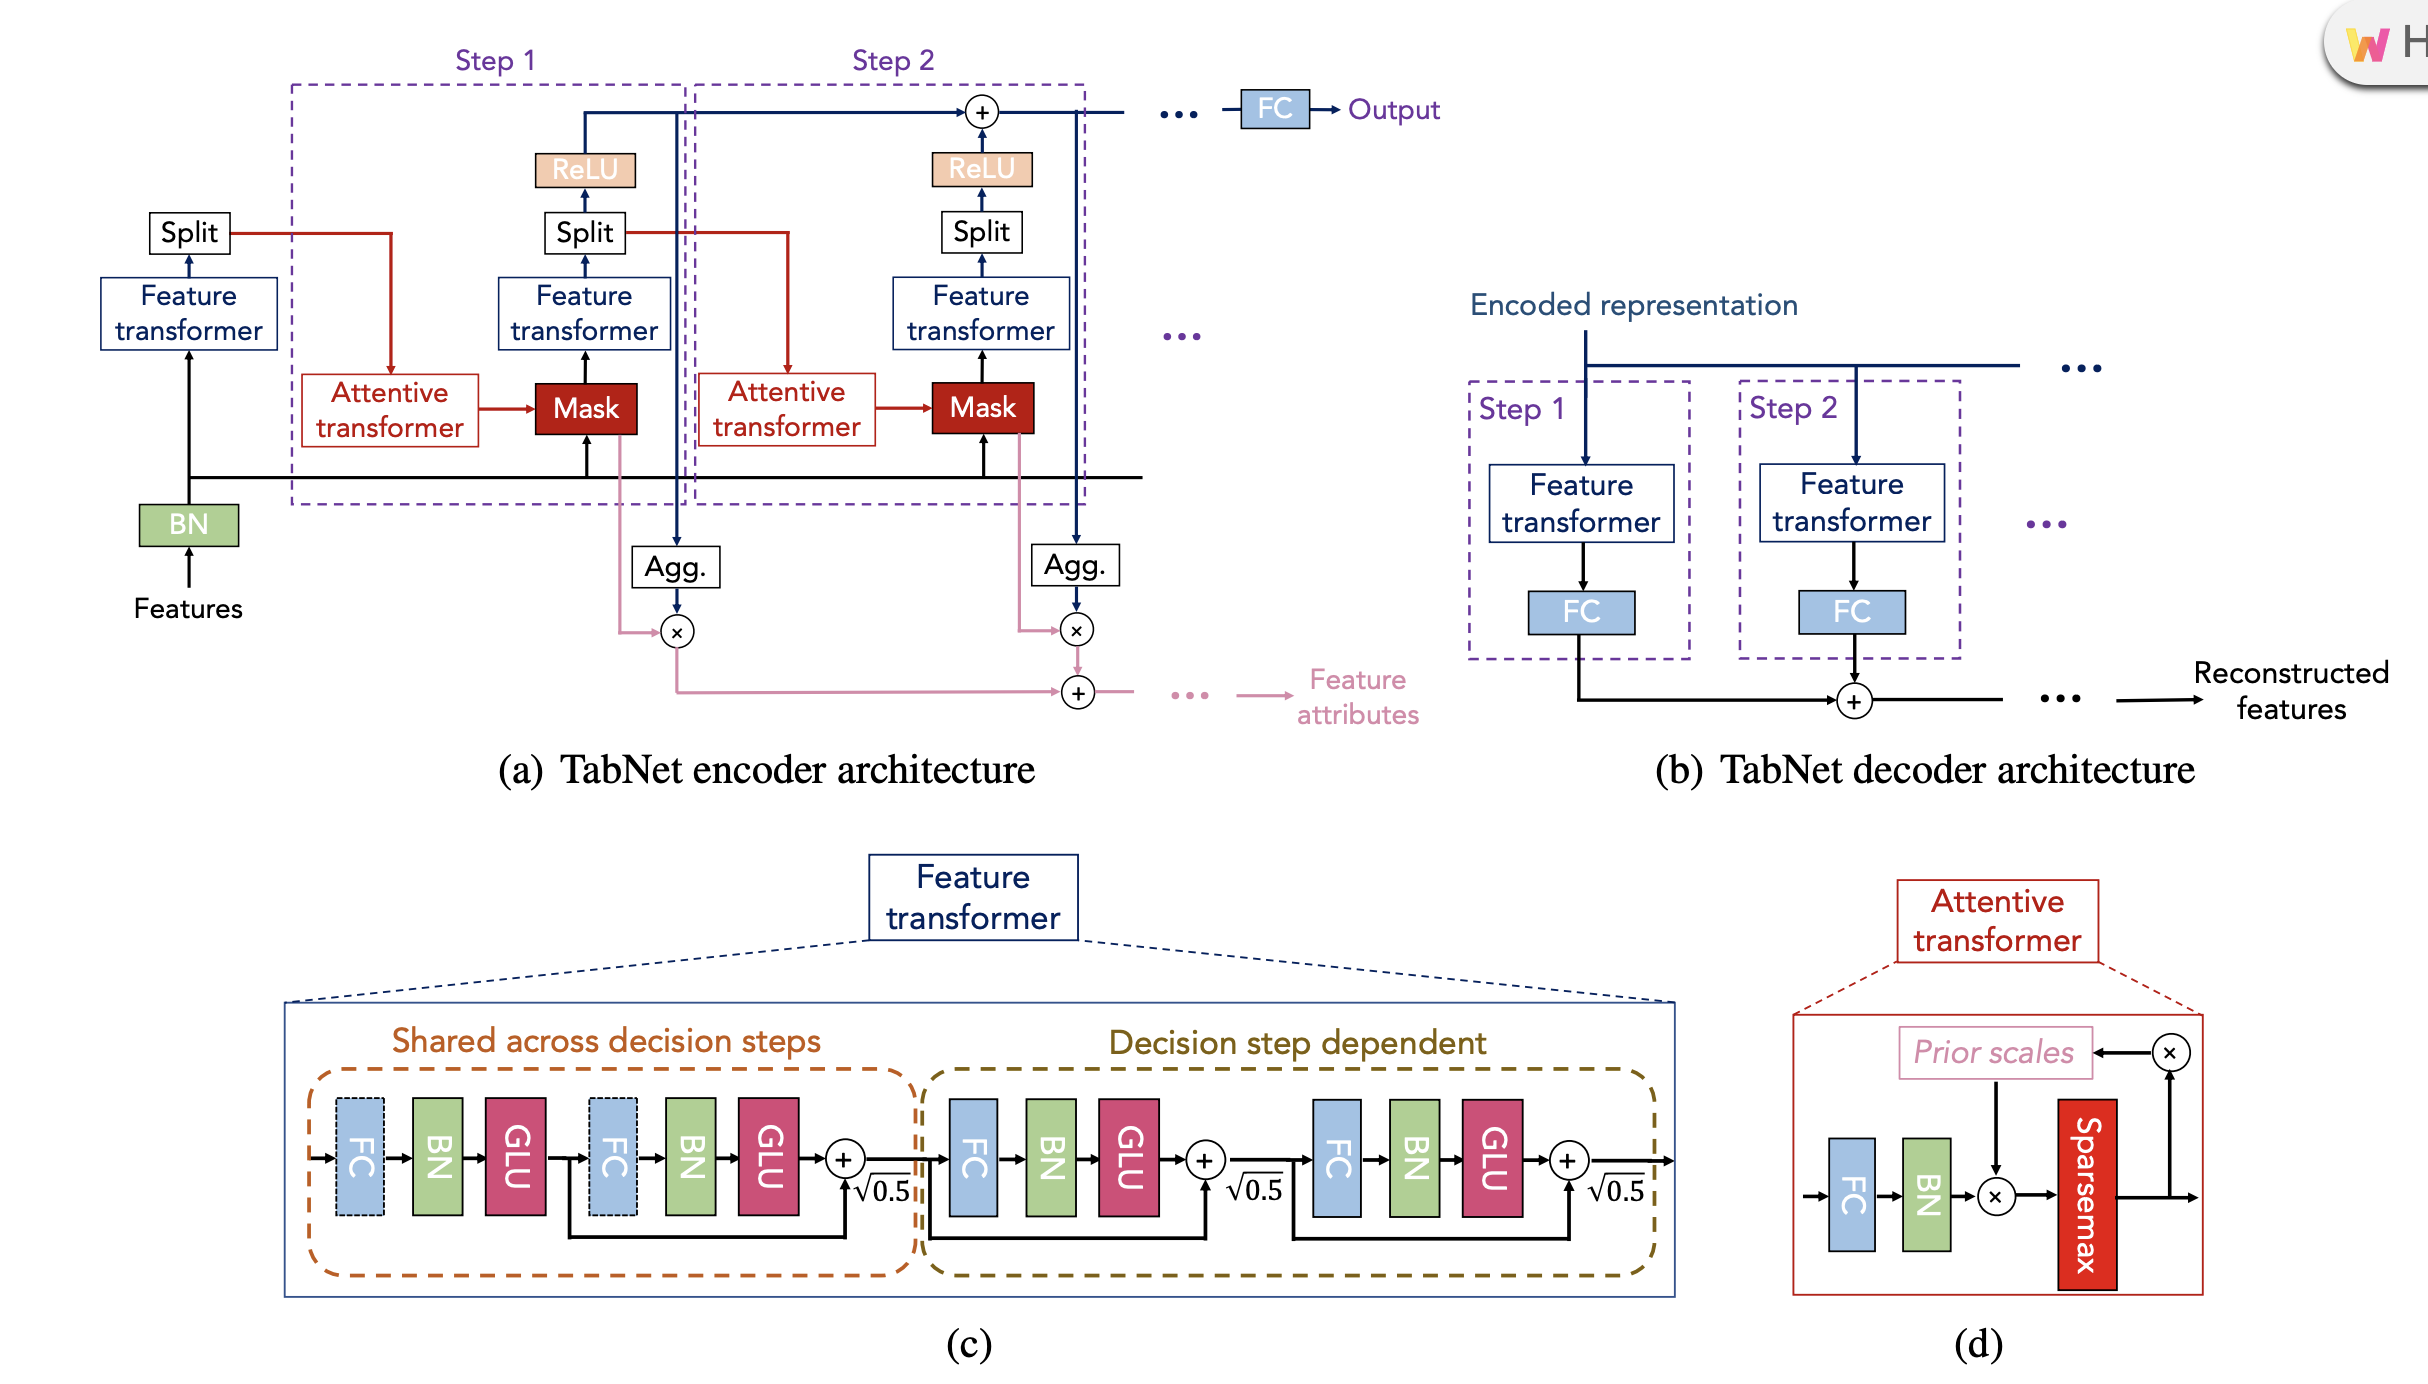

In [ ]:
from sklearn.preprocessing import LabelEncoder
!pip install pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#separate target(dependent)variable from features and create lists for numerical and categorical features
X = data.copy()
y = X.pop('default_payment_next_month')
categorical_features = list(X.select_dtypes("object").columns)
numerical_features = list(X.select_dtypes("number").columns)

In [ ]:
#deal with missing values in categorical features and encode them with LabelEncoder
#store number of unique categories per feature
category_num = {}
for column in categorical_features:
  label_encoder = LabelEncoder()
  X[column] = X[column].fillna('Missing')
  X[column] = label_encoder.fit_transform(X[column].values)
  category_num[column] = len(label_encoder.classes_)
category_num

{'sex': 3,
 'education': 5,
 'marriage': 4,
 'payment_status_sep': 10,
 'payment_status_aug': 10,
 'payment_status_jul': 10,
 'payment_status_jun': 10,
 'payment_status_may': 9,
 'payment_status_apr': 9}

In [ ]:
#create train/vaild/test split with 70-15-15:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_vaild, X_test, y_vaild, y_test = train_test_split(X_remain, y_remain, test_size=0.5, stratify=y_remain, random_state=42)

In [ ]:
#check
print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_vaild) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_vaild.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
Train: 70.00%
Valid: 15.00%
Test: 15.00%

Class distribution in each set ----
Train: [0.77880952 0.22119048]
Valid: [0.77888889 0.22111111]
Test: [0.77866667 0.22133333]


In [ ]:
#impute missing data in numerical features, filling with mean of training data
for column in numerical_features:
    impute_mean = X_train[column].mean()
    X_train[column] = X_train[column].fillna(impute_mean)
    X_vaild[column] = X_vaild[column].fillna(impute_mean)
    X_test[column] = X_test[column].fillna(impute_mean)

In [ ]:
#Prepare lists with indices of categorical features and no. of unique categories
features = X.columns.to_list()
categorical_index = [features.index(feature) for feature in categorical_features]
category_num = list(category_num.values())

In [ ]:
#define parameters and give an instance of classifier
#Reference: https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#model-parameters
TabNet_params = {"cat_idxs": categorical_index,
                 "cat_dims": category_num,
                 "optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=2e-2), #set by default
                 "scheduler_params": {"step_size":20,
                                      "gamma":0.9},
                 "scheduler_fn": torch.optim.lr_scheduler.StepLR, #change learning rates during training
                 "mask_type": "sparsemax",
                 "seed": 42}

tabnet = TabNetClassifier(**TabNet_params)

In [ ]:
tabnet.fit(X_train=X_train.values, 
          y_train=y_train.values,
          eval_set=[(X_train.values, y_train.values), 
                    (X_vaild.values, y_vaild.values)],
          eval_name=["train", "vaild"],
          eval_metric=["auc", "accuracy"],
          max_epochs=100, 
          patience=20,
          batch_size=1024, 
          virtual_batch_size=128,
          weights=1)

epoch 0  | loss: 0.71455 | train_auc: 0.64864 | train_accuracy: 0.74305 | vaild_auc: 0.63561 | vaild_accuracy: 0.73667 |  0:00:02s
epoch 1  | loss: 0.62386 | train_auc: 0.69869 | train_accuracy: 0.75548 | vaild_auc: 0.68931 | vaild_accuracy: 0.75178 |  0:00:04s
epoch 2  | loss: 0.60082 | train_auc: 0.72663 | train_accuracy: 0.75952 | vaild_auc: 0.71139 | vaild_accuracy: 0.76067 |  0:00:06s
epoch 3  | loss: 0.60245 | train_auc: 0.7311  | train_accuracy: 0.7871  | vaild_auc: 0.7177  | vaild_accuracy: 0.78267 |  0:00:08s
epoch 4  | loss: 0.59343 | train_auc: 0.73995 | train_accuracy: 0.78562 | vaild_auc: 0.732   | vaild_accuracy: 0.78222 |  0:00:10s
epoch 5  | loss: 0.58658 | train_auc: 0.74297 | train_accuracy: 0.78524 | vaild_auc: 0.72955 | vaild_accuracy: 0.78244 |  0:00:13s
epoch 6  | loss: 0.58924 | train_auc: 0.75608 | train_accuracy: 0.783   | vaild_auc: 0.74015 | vaild_accuracy: 0.77756 |  0:00:16s
epoch 7  | loss: 0.58139 | train_auc: 0.7604  | train_accuracy: 0.79067 | vaild_auc

In [ ]:
history_record = pd.DataFrame(tabnet.history.history)
history_record.head()

,loss,lr,train_auc,train_accuracy,vaild_auc,vaild_accuracy
0,0.714554,0.02,0.648643,0.743048,0.635610,0.736667
1,0.623857,0.02,0.698694,0.755476,0.689308,0.751778
2,0.600816,0.02,0.726628,0.759524,0.711385,0.760667
3,0.602453,0.02,0.731095,0.787095,0.717703,0.782667
4,0.593427,0.02,0.739951,0.785619,0.731996,0.782222


<Axes: title={'center': 'Loss per epochs'}, xlabel='epochs', ylabel='loss'>

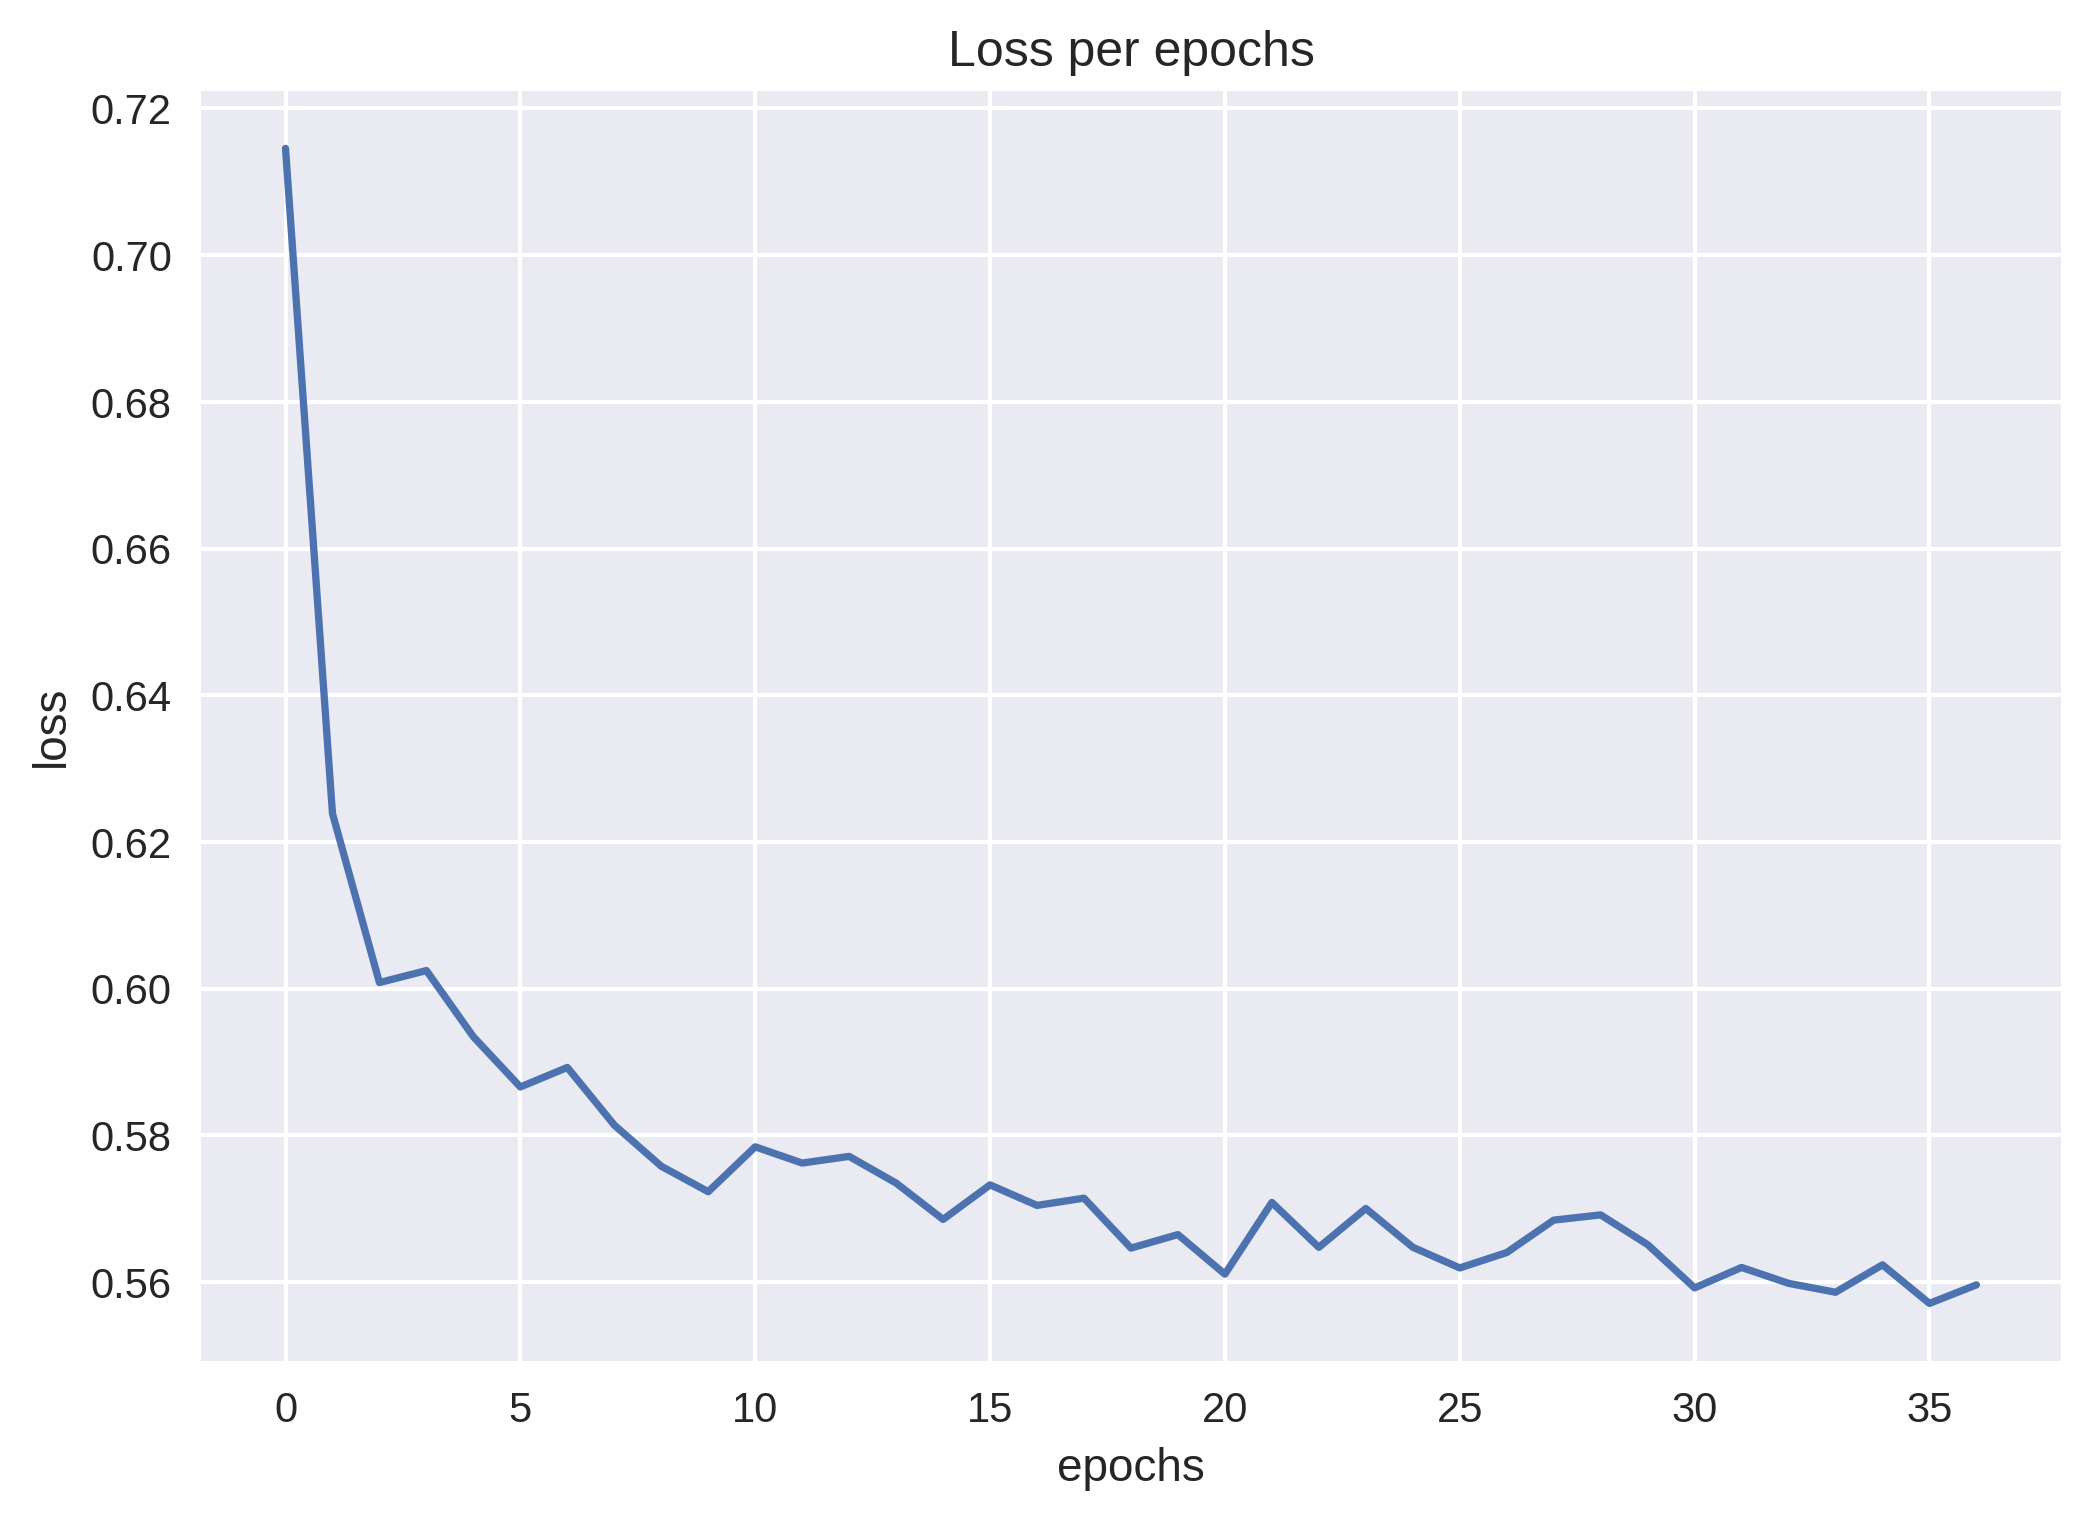

In [ ]:
#plot loss curve
history_record["loss"].plot(title="Loss per epochs",
                            xlabel="epochs",
                            ylabel="loss")

<Axes: title={'center': 'AUC per epochs'}, xlabel='epochs', ylabel='AUC'>

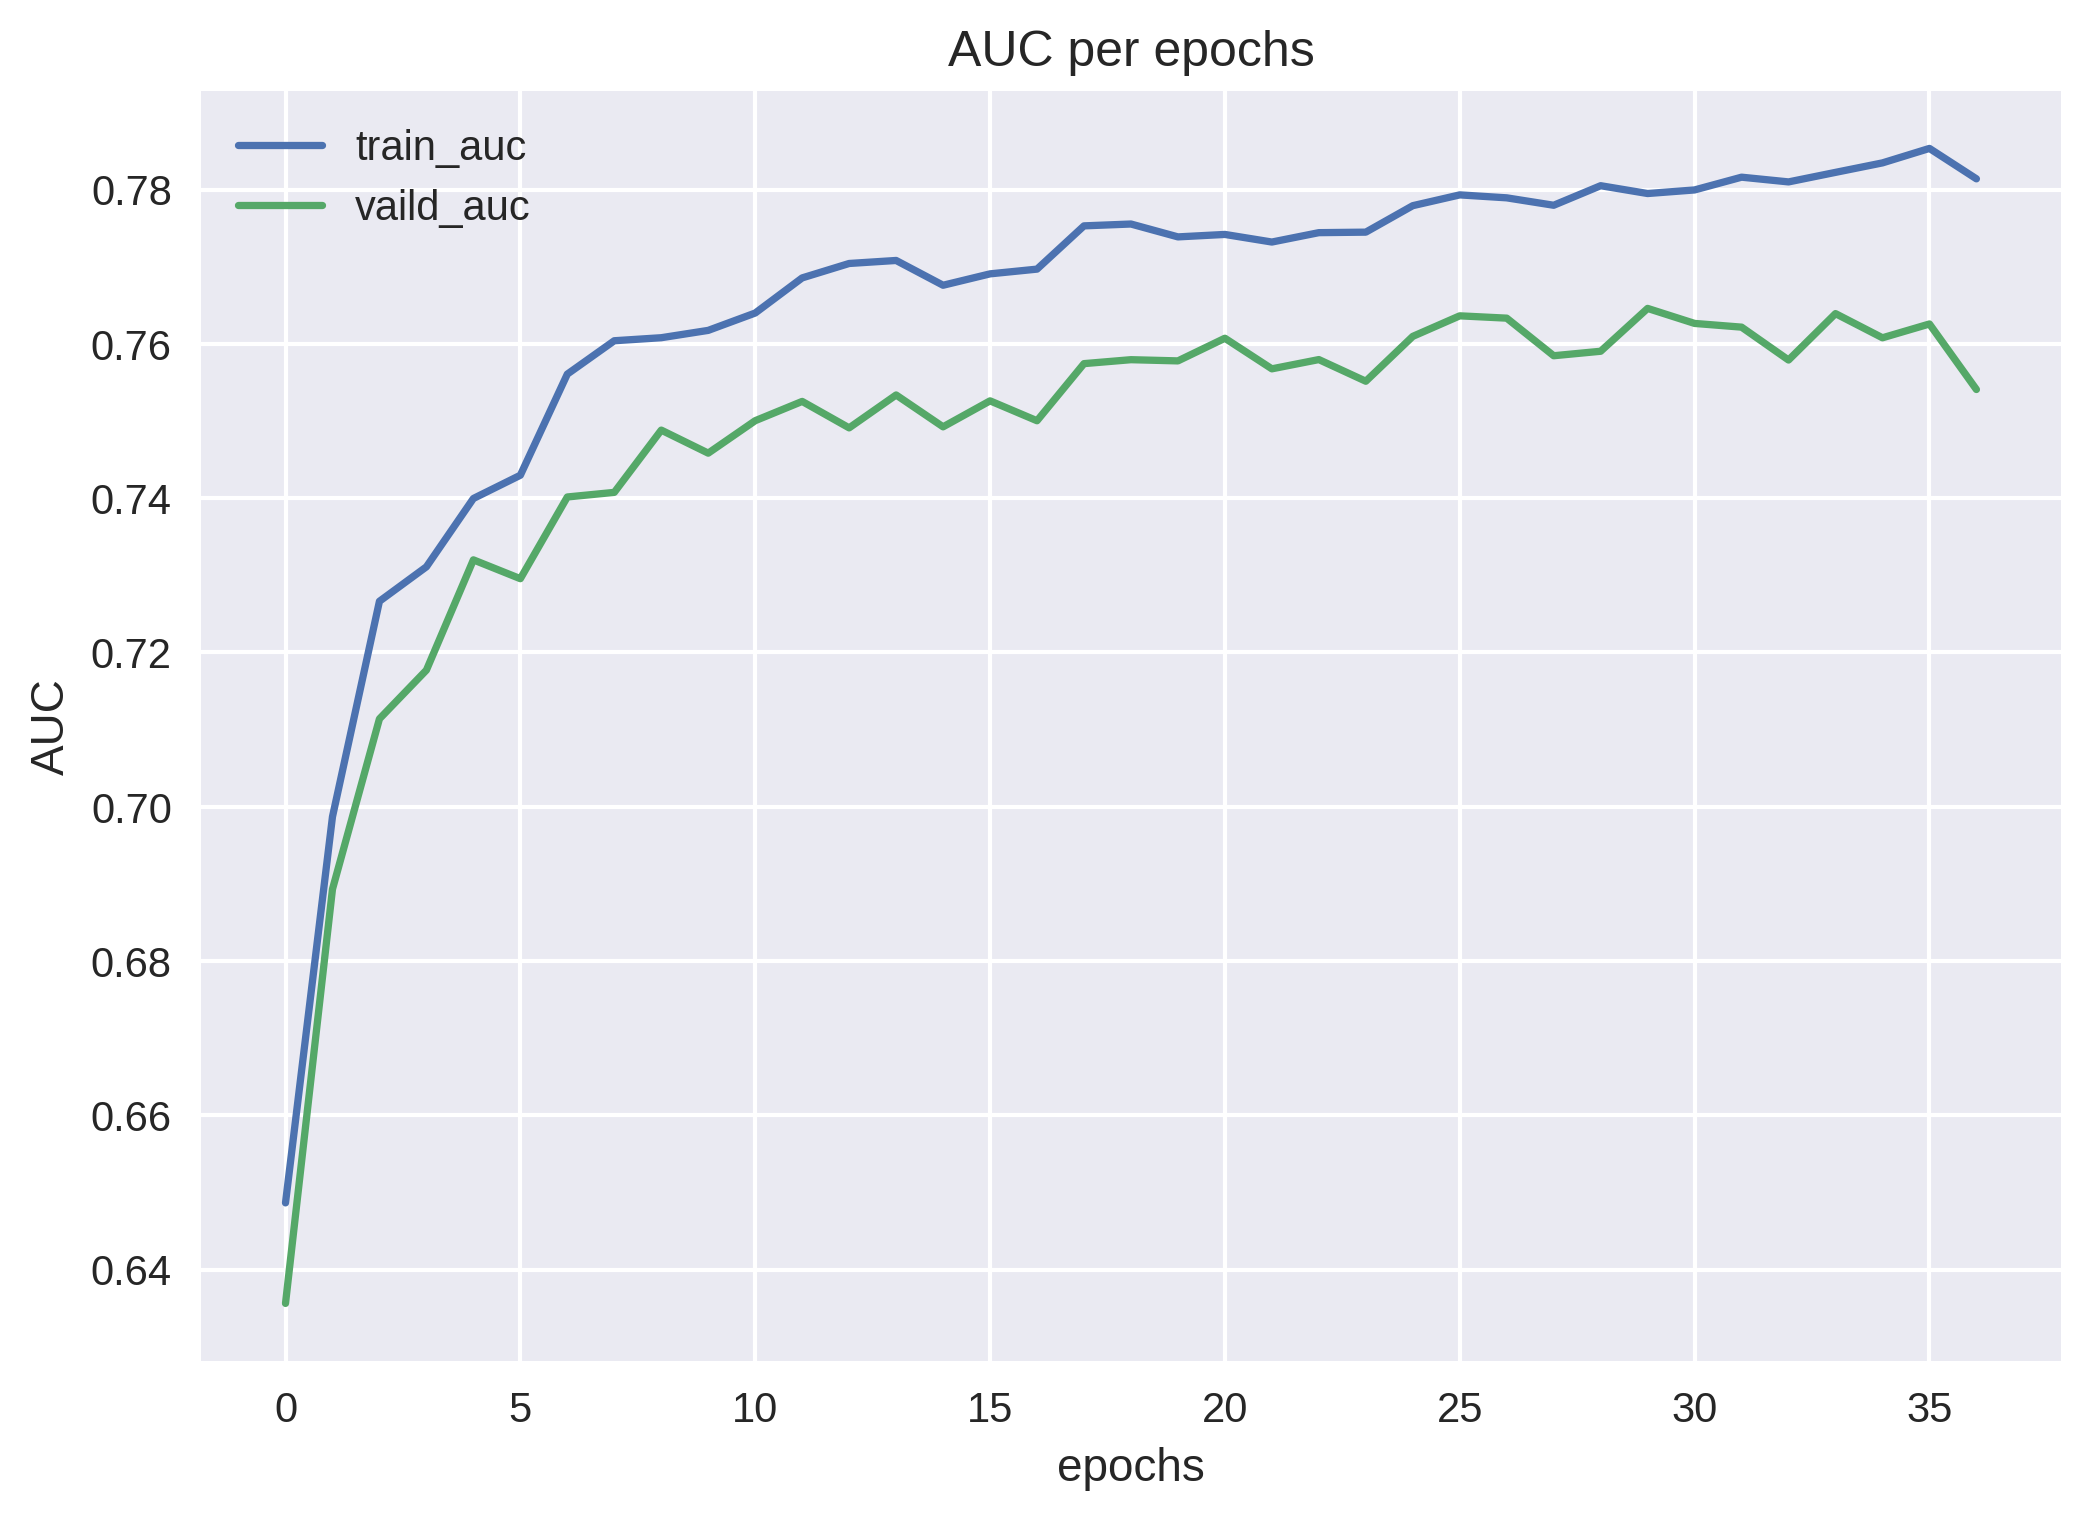

In [ ]:
history_record[["train_auc", "vaild_auc"]].plot(title="AUC per epochs",
                                                xlabel="epochs",
                                                ylabel="AUC")

<Axes: title={'center': 'Acurracy per epochs'}, xlabel='epochs', ylabel='accuracy'>

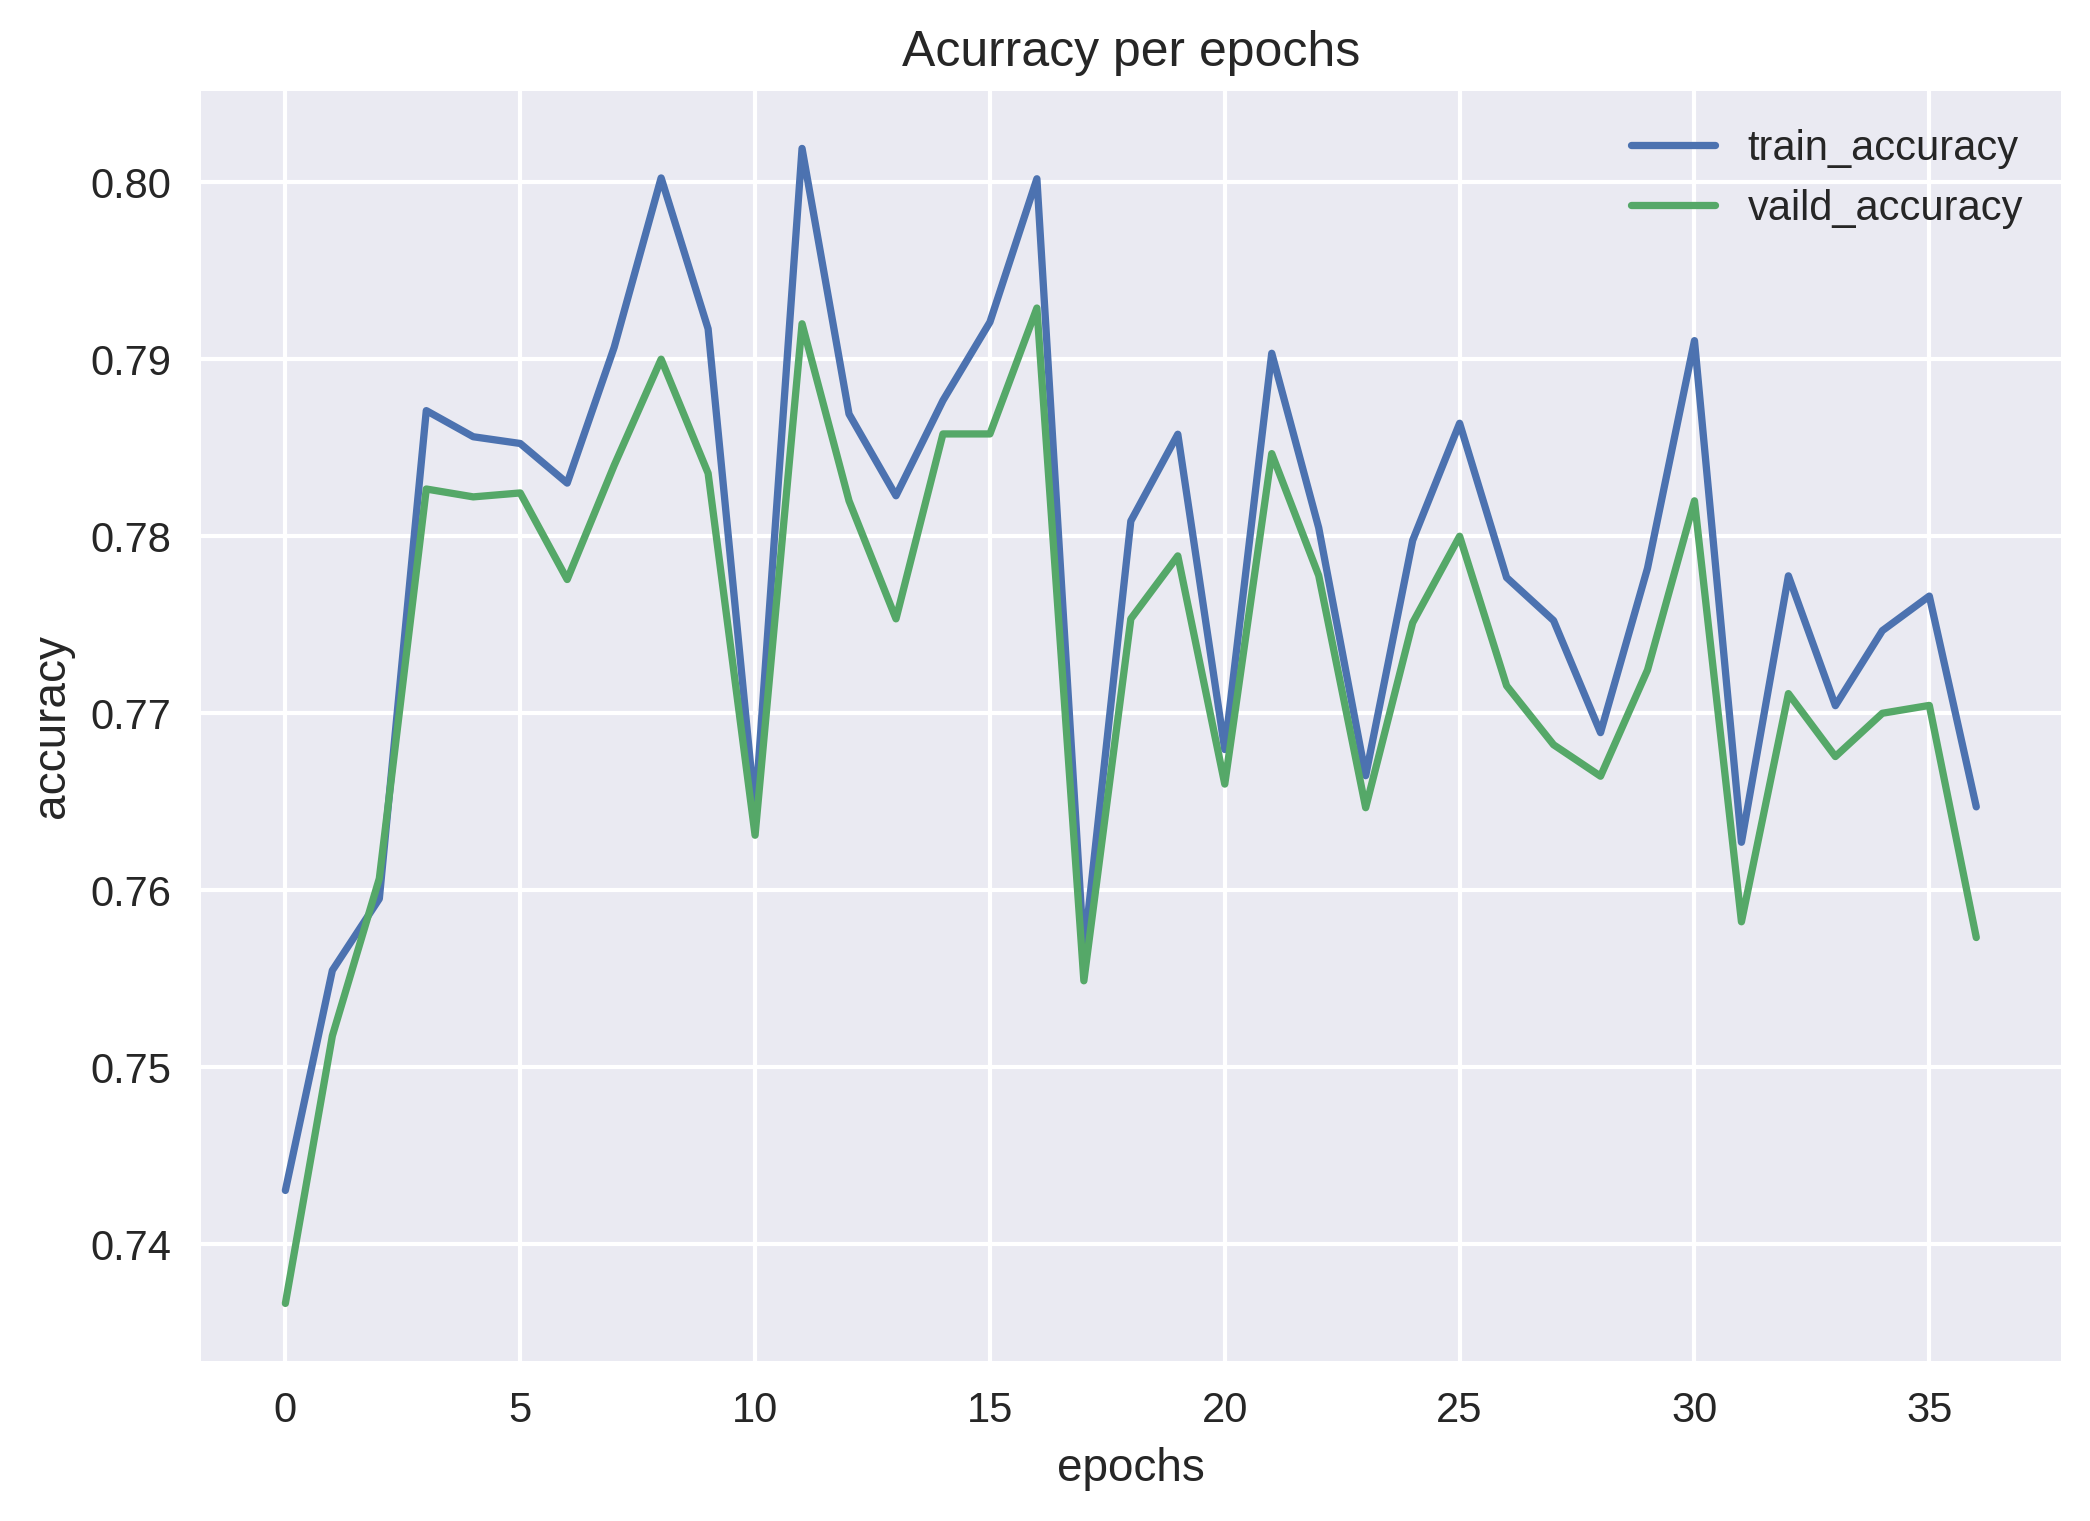

In [ ]:
history_record[["train_accuracy", "vaild_accuracy"]].plot(title="Acurracy per epochs",
                                                          xlabel="epochs",
                                                          ylabel="accuracy")

In [ ]:
#make prediction of test data and performance evaluation
y_pred = tabnet.predict(X_test.values)
print(f"Best validation score: {tabnet.best_cost:.4f}")

Best validation score: 0.7929


<Axes: title={'center': 'TabNet Feature Importances'}>

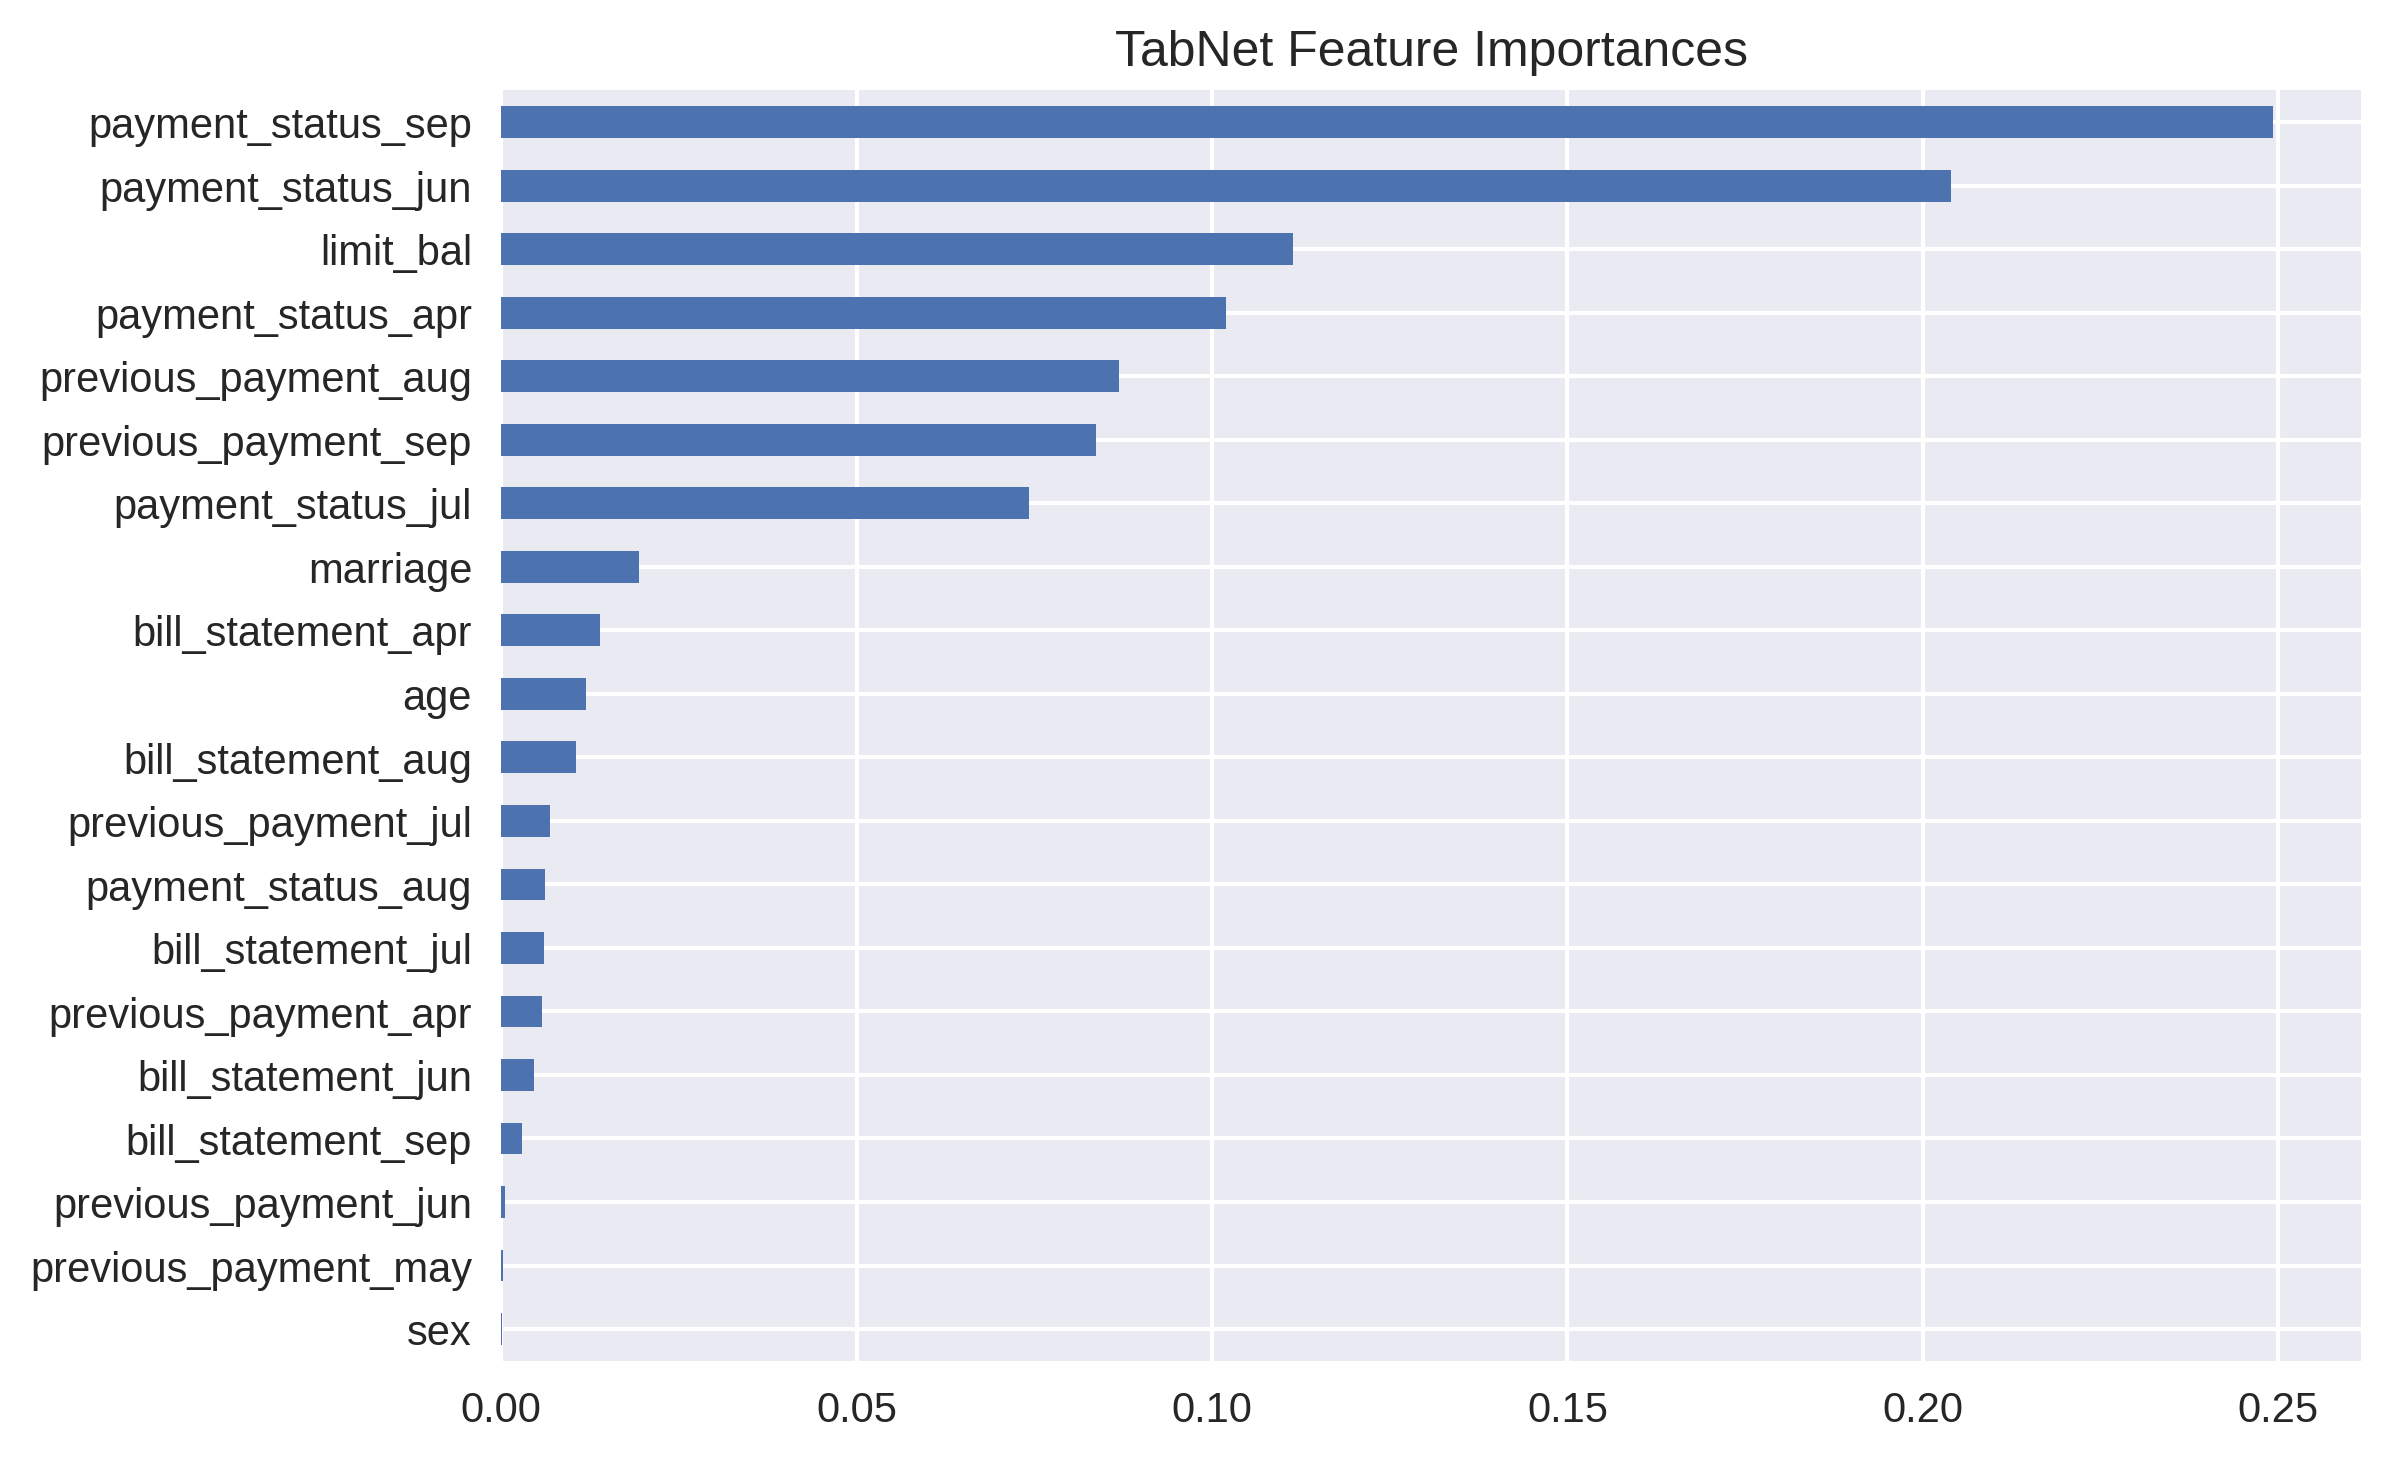

In [ ]:
tabnet_feature_importance = pd.Series(tabnet.feature_importances_, index=X_train.columns)
tabnet_feature_importance.nlargest(20).sort_values().plot(kind="barh",title="TabNet Feature Importances")

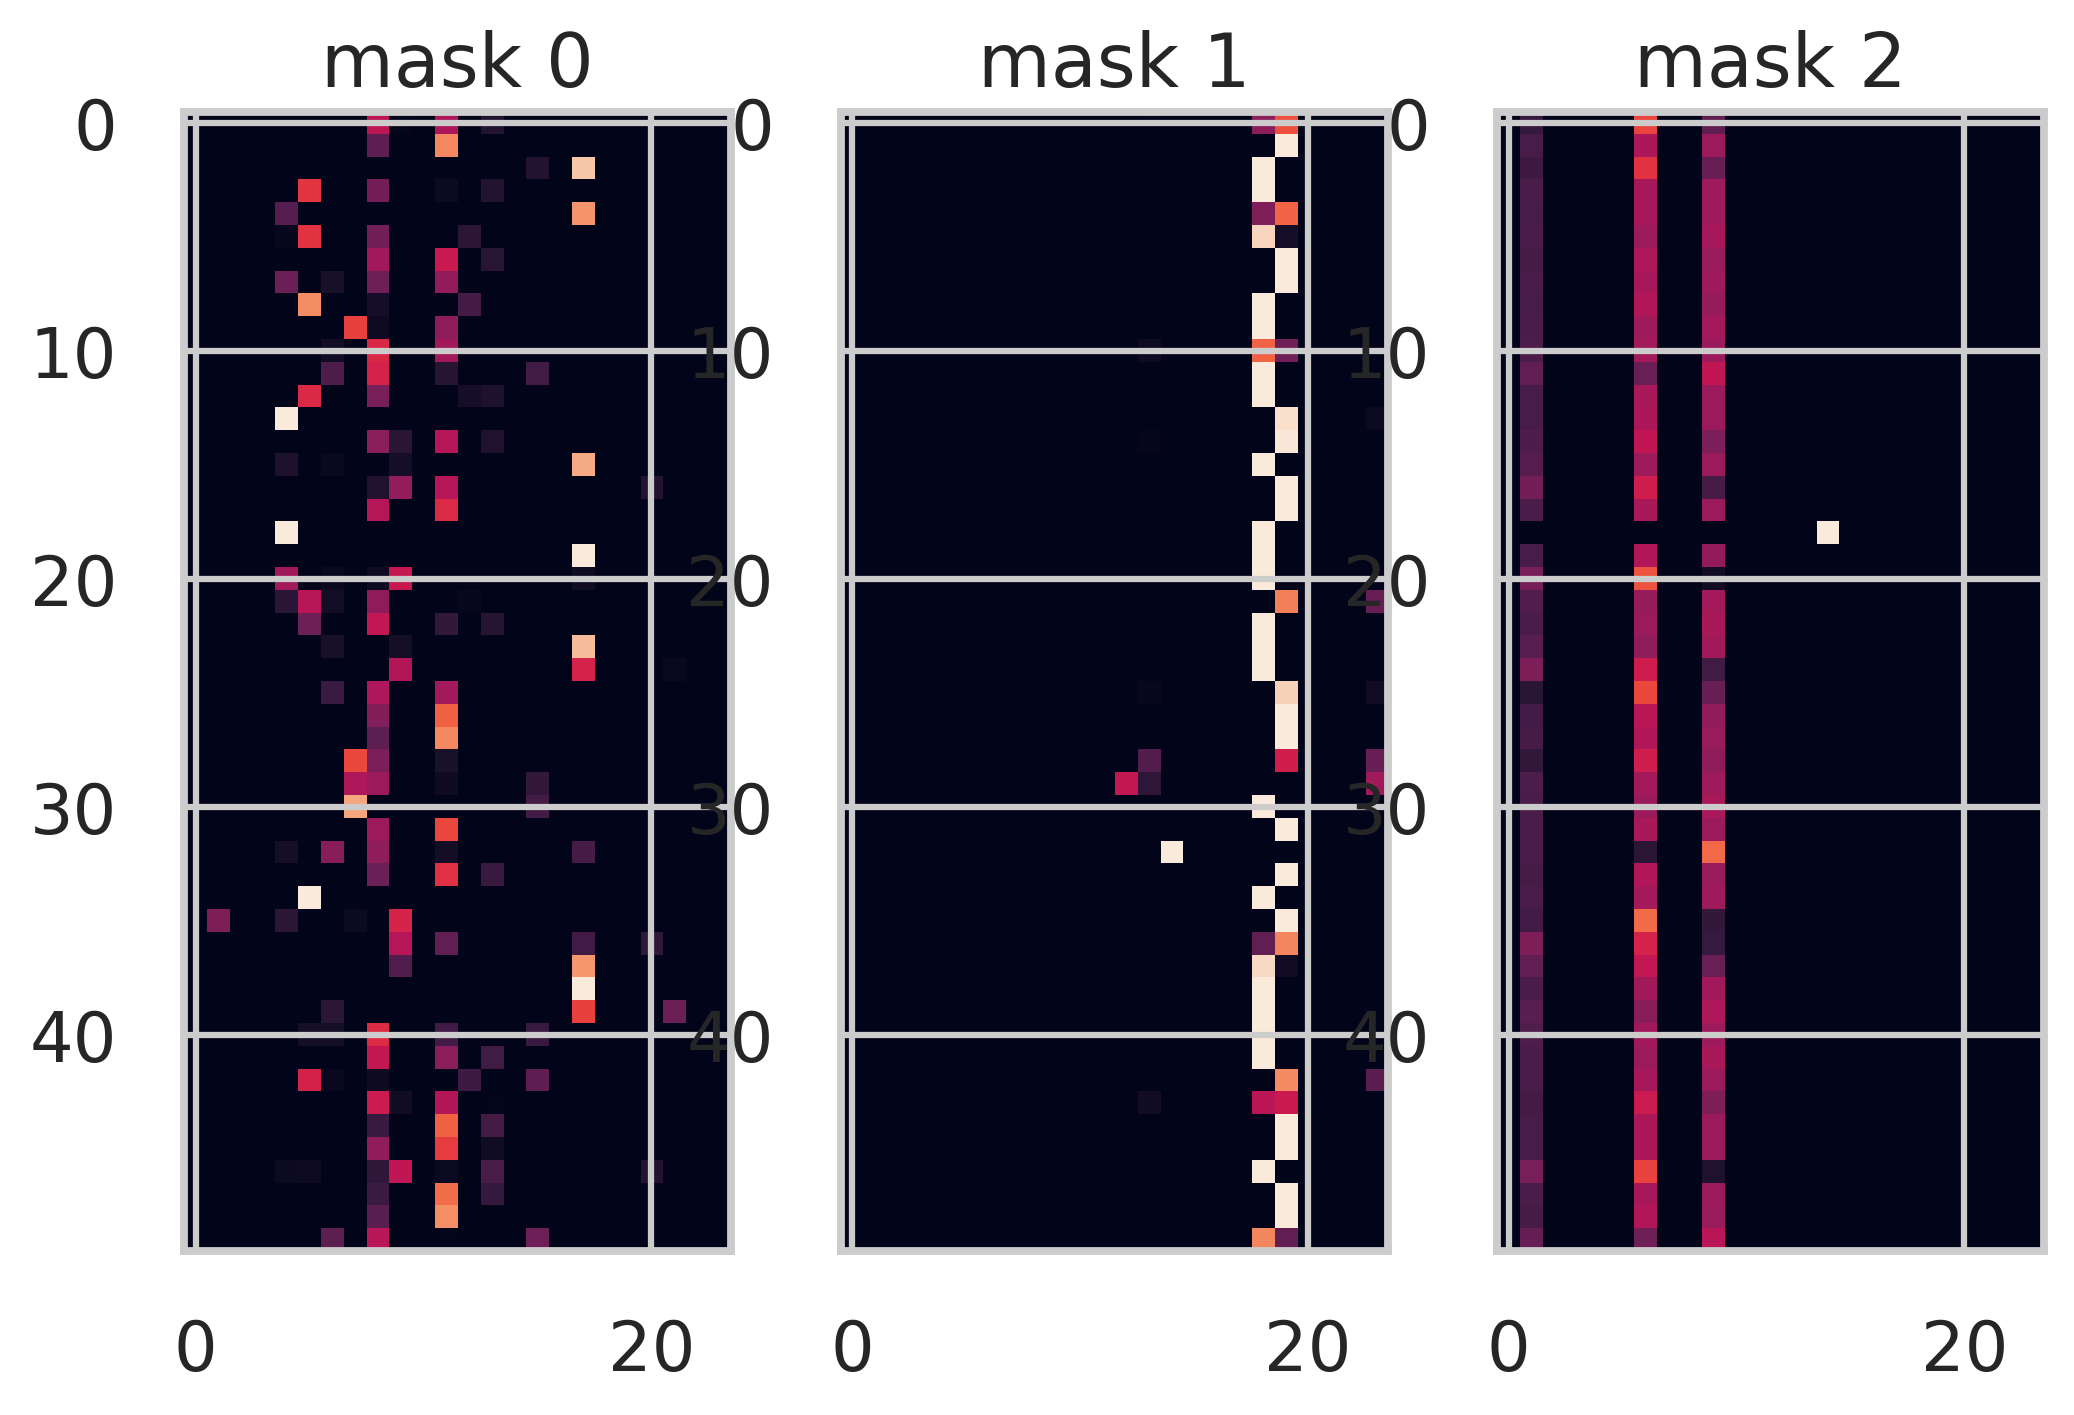

In [ ]:
sns.set_theme(context="talk", 
              style="whitegrid", 
              palette="colorblind", 
              color_codes=True)
explain_matrix, masks = tabnet.explain(X_test.values)
fig, axs = plt.subplots(1, 3)
for i in range(3):
  axs[i].imshow(masks[i][:50])
  axs[i].set_title(f"mask {i}")

## CNNs for Time Series Forecasting

In [5]:
!pip install yfinance
import yfinance as yf
import torch.optim as optim #https://pytorch.org/docs/stable/optim.html
import torch.nn as nn
from sklearn.metrics import mean_squared_error
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset #https://pytorch.org/docs/stable/data.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
def create_input_data(series, n_lags=1, n_leads=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : The time series to be transformed
    n_lags : int. The number of lagged observations to consider as features
    n_leads : The number of future periods we want to forecast for
        
    Returns
    -------
    X : features
    y : target
    '''
    X = []
    y = []
    for step in range(len(series) - n_lags - n_leads + 1):
        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end])
    return np.array(X), np.array(y)

# custom function for reproducibility
def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
#import weekly data and define the vaildation dataset range
nvda=yf.download('NVDA', '2019-01-01','2023-05-31', progress=False)['Adj Close'].resample('W-MON').last()
valid_size=nvda.loc['2022-06-30':'2023-05-31'].shape[0]

In [8]:
nvda.head()

Date
2019-01-07    35.577587
2019-01-14    37.324223
2019-01-21    38.934391
2019-01-28    34.240334
2019-02-04    37.011608
Freq: W-MON, Name: Adj Close, dtype: float64

[Text(0.5, 1.0, 'NVDA Stock Price'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Price$')]

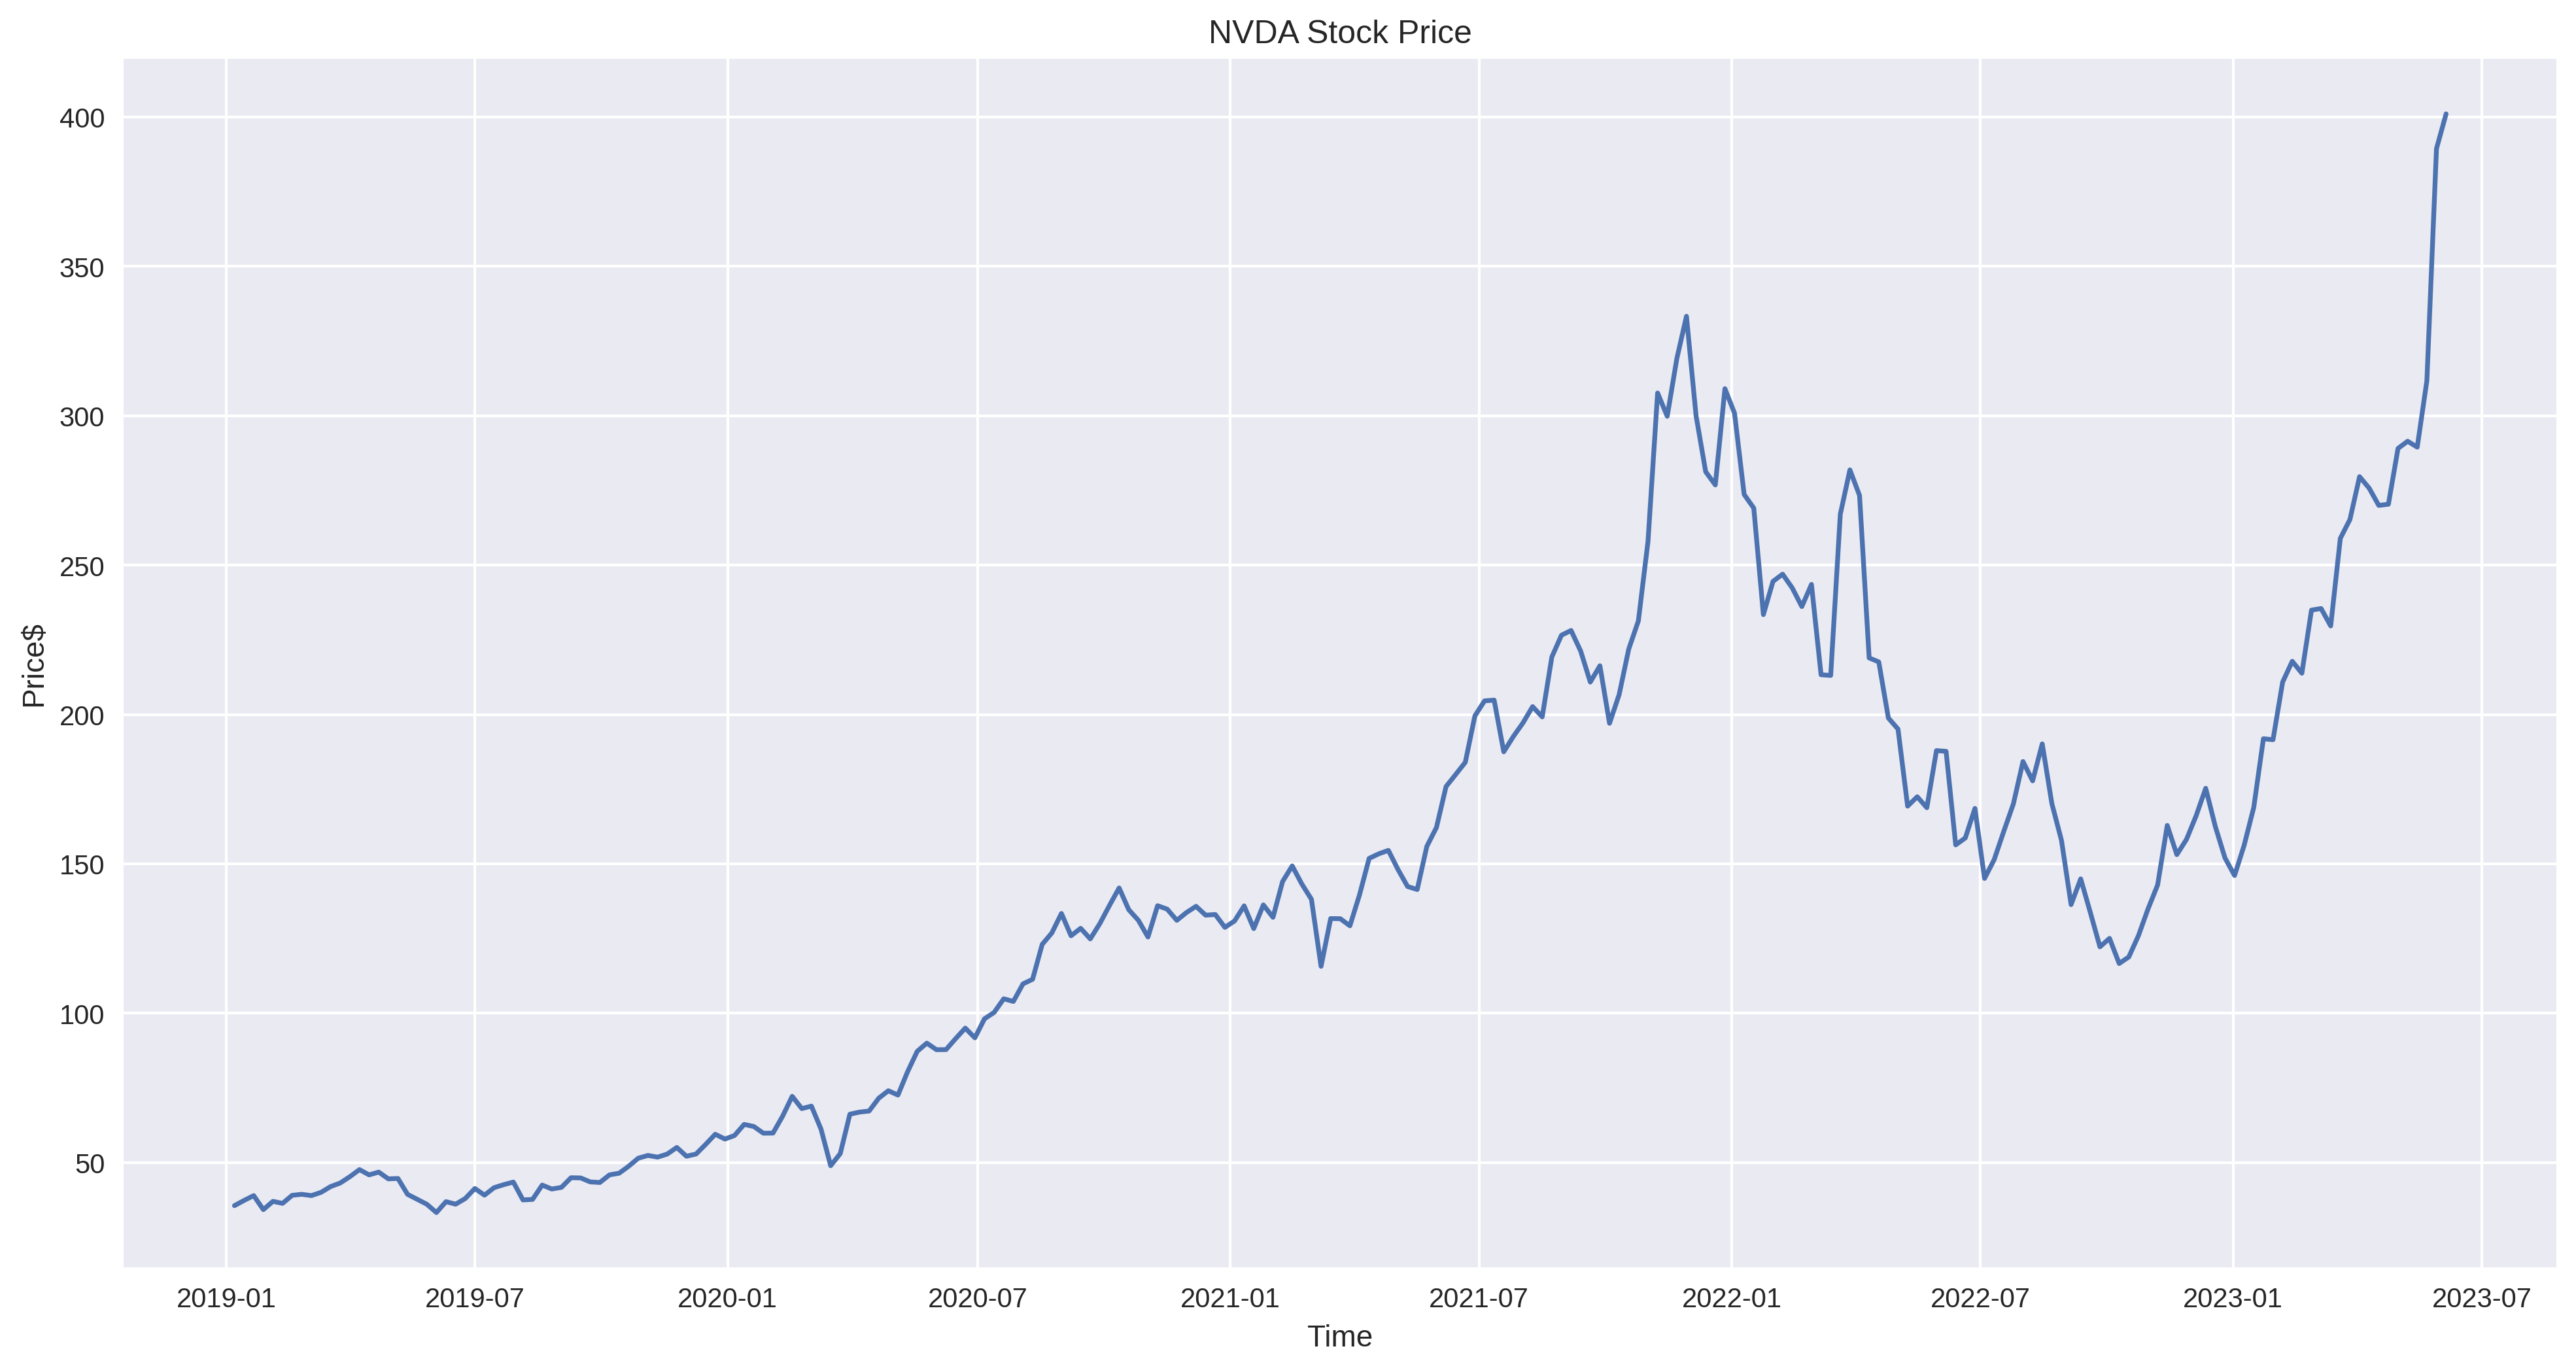

In [9]:
#graph the weekly price of NVDA
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(nvda.index, nvda.values)
ax.set(title="NVDA Stock Price", xlabel='Time', ylabel='Price$')

In [11]:
#transform time series data to the input of CNN model
X, y = create_input_data(nvda.values, n_lags=12)

In [12]:
#get a naive forcast
naive_pred = nvda.values[len(nvda.values) - valid_size - 1:-1]
y_valid = nvda.values[len(nvda.values) - valid_size:]
naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 272.85, RMSE: 16.52


In [13]:
custom_set_seed(42)

valid_ind = len(X) - valid_size
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)
dataset = TensorDataset(X_tensor, y_tensor)
train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))
train_loader = DataLoader(dataset=train_dataset, batch_size=5)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=5)

In [14]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
                                   ('max_pool_1', nn.MaxPool1d(2)),
                                   ('relu_1', nn.ReLU()),
                                   ('flatten', Flatten()),
                                   ('fc_1', nn.Linear(192, 50)),
                                   ('relu_2', nn.ReLU()),
                                   ('dropout_1', nn.Dropout(0.4)),
                                   ('fc_2', nn.Linear(50, 1))]))
print(model)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


In [15]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#train the network
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(12):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, 12)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, 12)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './cnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()
plt.show()